1st

In [1]:
import json
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from rank_bm25 import BM25Okapi
import numpy as np
import pandas as pd

 
class DataPreprocessor:
    def __init__(self, model_name='paraphrase-MiniLM-L6-v2'):
        """
        Initialize the Data Preprocessor with required models and tools
        
        Args:
            model_name (str): The SentenceTransformer model to use for embeddings
        """
        self.stop_words = set(stopwords.words('english'))
        self.sentence_model = SentenceTransformer(model_name)
        self.tfidf_vectorizer = TfidfVectorizer()
        self.bm25 = None
        self.processed_data = None
        self.embeddings = None
        
    def load_dataset(self, file_paths):
        """
        Load and merge multiple legal QA datasets
        
        Args:
            file_paths (dict): Dictionary mapping dataset names to file paths
            
        Returns:
            pandas.DataFrame: Combined dataset
        """
        combined_data = []
        
        for dataset_name, file_path in file_paths.items():
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                # Handle different possible JSON structures
                if isinstance(data, list):
                    for item in data:
                        if isinstance(item, dict):
                            item['source'] = dataset_name
                            combined_data.append(item)
                elif isinstance(data, dict):
                    for key, item in data.items():
                        if isinstance(item, dict):
                            item['source'] = dataset_name
                            item['id'] = key
                            combined_data.append(item)
                
                print(f"Successfully loaded {len(data)} QA pairs from {dataset_name}")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
        
        # Create DataFrame and ensure required columns
        df = pd.DataFrame(combined_data)
        
        # Standardize column names if needed
        if 'question' not in df.columns and 'Question' in df.columns:
            df = df.rename(columns={'Question': 'question'})
        if 'answer' not in df.columns and 'Answer' in df.columns:
            df = df.rename(columns={'Answer': 'answer'})
            
        print(f"Combined dataset contains {len(df)} QA pairs")
        return df
    
    def normalize_text(self, text):
        """
        Normalize text by removing special characters, extra spaces, etc.
        
        Args:
            text (str): Input text to normalize
            
        Returns:
            str: Normalized text
        """
        if not isinstance(text, str):
            return ""
            
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters but keep legal symbols like §, ¶
        text = re.sub(r'[^\w\s§¶.,-]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_text(self, text):
        """
        Tokenize text into words, removing stopwords
        
        Args:
            text (str): Input text to tokenize
            
        Returns:
            list: List of tokens
        """
        if not isinstance(text, str):
            return []
            
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        tokens = [token for token in tokens if token.lower() not in self.stop_words]
        
        return tokens
    
    def preprocess_dataset(self, df):
        """
        Apply preprocessing to the entire dataset
        
        Args:
            df (pandas.DataFrame): Dataset with questions and answers
            
        Returns:
            pandas.DataFrame: Preprocessed dataset
        """
        # Make a copy to avoid modifying the original
        processed_df = df.copy()
        
        # Normalize questions and answers
        processed_df['normalized_question'] = processed_df['question'].apply(self.normalize_text)
        processed_df['normalized_answer'] = processed_df['answer'].apply(self.normalize_text)
        
        # Tokenize questions and answers
        processed_df['tokenized_question'] = processed_df['normalized_question'].apply(self.tokenize_text)
        processed_df['tokenized_answer'] = processed_df['normalized_answer'].apply(self.tokenize_text)
        
        # Create a combined field for context retrieval
        processed_df['combined_text'] = processed_df['normalized_question'] + " " + processed_df['normalized_answer']
        
        self.processed_data = processed_df
        return processed_df
    
    def generate_embeddings(self):
        """
        Generate embeddings for questions and answers using SentenceTransformer
        
        Returns:
            dict: Dictionary containing question and answer embeddings
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Call preprocess_dataset first.")
        
        print("Generating embeddings for questions...")
        question_embeddings = self.sentence_model.encode(
            self.processed_data['normalized_question'].tolist(),
            show_progress_bar=True
        )
        
        print("Generating embeddings for answers...")
        answer_embeddings = self.sentence_model.encode(
            self.processed_data['normalized_answer'].tolist(),
            show_progress_bar=True
        )
        
        self.embeddings = {
            'question': question_embeddings,
            'answer': answer_embeddings
        }
        
        return self.embeddings
    
    def build_tfidf_index(self):
        """
        Build TF-IDF vectors for questions and combined text
        
        Returns:
            dict: Dictionary containing TF-IDF matrices
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Call preprocess_dataset first.")
        
        # Fit TF-IDF on questions
        question_tfidf = self.tfidf_vectorizer.fit_transform(self.processed_data['normalized_question'])
        
        # Create a new vectorizer for combined text
        combined_vectorizer = TfidfVectorizer()
        combined_tfidf = combined_vectorizer.fit_transform(self.processed_data['combined_text'])
        
        return {
            'question_tfidf': question_tfidf,
            'question_vectorizer': self.tfidf_vectorizer,
            'combined_tfidf': combined_tfidf,
            'combined_vectorizer': combined_vectorizer
        }
    
    def build_bm25_index(self):
        """
        Build BM25 index for efficient retrieval
        
        Returns:
            BM25Okapi: BM25 index object
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Call preprocess_dataset first.")
        
        # Prepare corpus for BM25
        tokenized_corpus = self.processed_data['tokenized_question'].tolist()
        
        # Initialize BM25
        self.bm25 = BM25Okapi(tokenized_corpus)
        
        return self.bm25
    
    def save_processed_data(self, output_path):
        """
        Save processed data to disk
        
        Args:
            output_path (str): Path to save the processed data
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Call preprocess_dataset first.")
        
        # Convert embeddings to lists for JSON serialization
        if self.embeddings is not None:
            embeddings_dict = {
                'question': self.embeddings['question'].tolist(),
                'answer': self.embeddings['answer'].tolist()
            }
            
            # Save embeddings separately as they can be large
            np.save(f"{output_path}_embeddings.npy", self.embeddings)
        
        # Prepare data for saving
        save_data = {
            'processed_df': self.processed_data.to_dict(orient='records'),
            'metadata': {
                'num_samples': len(self.processed_data),
                'sources': self.processed_data['source'].unique().tolist(),
                'embedding_model': self.sentence_model.get_sentence_embedding_dimension()
            }
        }
        
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(save_data, f)
            
        print(f"Processed data saved to {output_path}")

2nd

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import json
 
 
class QuestionClassifier:
    def __init__(self):
        """
        Initialize the Question Classification Component using Bayesian approach
        """
        # Use 'english' as a string instead of the set for sklearn compatibility
        self.stop_words = 'english'
        self.question_types = [
            'DEFINITION',
            'FACTUAL',
            'LEGAL_PROVISION',
            'PROCEDURE',
            'RIGHTS',
            'EXCEPTION',
            'COMPARISON',
            'CONSEQUENCE',
            'JURISDICTION',
            'TIMEFRAME'
        ]
        self.classifier = None
        self.vectorizer = None
        self.keywords = self._init_keywords()
        self.syntactic_patterns = self._init_syntactic_patterns()
        
    def _init_keywords(self):
        """
        Initialize keyword lists for different question types
        
        Returns:
            dict: Dictionary mapping question types to associated keywords
        """
        return {
            'DEFINITION': [
                'what is', 'define', 'meaning', 'description', 'explain',
                'concept', 'refer to', 'constitute', 'definition', 'termed'
            ],
            'FACTUAL': [
                'who', 'when', 'where', 'which', 'how many', 'list',
                'name', 'identify', 'mention', 'specify'
            ],
            'LEGAL_PROVISION': [
                'section', 'provision', 'article', 'clause', 'rule', 
                'act', 'statute', 'law', 'regulation', 'ordinance', 'code'
            ],
            'PROCEDURE': [
                'how to', 'process', 'steps', 'procedure', 'method',
                'way', 'approach', 'protocol', 'file', 'submit', 'apply'
            ],
            'RIGHTS': [
                'right', 'entitle', 'claim', 'privilege', 'protection',
                'freedom', 'liberty', 'enable', 'permit', 'allow'
            ],
            'EXCEPTION': [
                'exception', 'exempt', 'waive', 'excuse', 'exclude',
                'unless', 'except', 'other than', 'apart from', 'besides'
            ],
            'COMPARISON': [
                'compare', 'contrast', 'difference', 'distinguish', 'versus',
                'differentiate', 'similar', 'differ', 'relate', 'connection'
            ],
            'CONSEQUENCE': [
                'penalty', 'punishment', 'sanction', 'outcome', 'result',
                'effect', 'consequence', 'implication', 'lead to', 'happen if'
            ],
            'JURISDICTION': [
                'jurisdiction', 'authority', 'power', 'control', 'competence',
                'court', 'tribunal', 'forum', 'bench', 'judiciary'
            ],
            'TIMEFRAME': [
                'deadline', 'time limit', 'period', 'duration', 'within',
                'by when', 'limitation', 'expire', 'extend', 'timeline'
            ]
        }
    
    def _init_syntactic_patterns(self):
        """
        Initialize syntactic patterns for question classification
        
        Returns:
            dict: Dictionary of regex patterns for different question types
        """
        return {
            'DEFINITION': [
                r'^what\s+(is|are|does|do)\s+(.+?)\s+(mean|refer\s+to)',
                r'^(define|explain)\s+(.+)',
                r'^(meaning|definition)\s+of\s+(.+)',
                r'what\s+constitutes\s+(.+)'
            ],
            'FACTUAL': [
                r'^who\s+(.+)',
                r'^when\s+(.+)',
                r'^where\s+(.+)',
                r'^which\s+(.+)',
                r'^(how\s+many|list|name|mention|specify)\s+(.+)'
            ],
            'LEGAL_PROVISION': [
                r'(section|article|clause|rule)\s+\d+',
                r'under\s+(what|which)\s+(section|provision|article|clause|rule)',
                r'(which|what)\s+(act|statute|law|regulation)'
            ],
            'PROCEDURE': [
                r'^how\s+to\s+(.+)',
                r'^what\s+(is|are)\s+the\s+(steps|procedure|process)',
                r'^(describe|explain)\s+the\s+(procedure|process|method)',
                r'how\s+(can|should|do|does|is)\s+(.+?)\s+(done|filed|submitted|processed)'
            ],
            'RIGHTS': [
                r'(what|which)\s+(rights|entitlements)',
                r'(am|is|are)\s+(.+?)\s+(entitled|allowed|permitted)',
                r'(can|may)\s+(.+?)\s+(claim|exercise|demand)'
            ],
            'EXCEPTION': [
                r'(what|which|any)\s+(exceptions|exemptions)',
                r'(except|exempted|excluded|waived)',
                r'(unless|except\s+for|other\s+than|apart\s+from)'
            ],
            'COMPARISON': [
                r'(difference|distinguish|compare)\s+between\s+(.+?)\s+and\s+(.+)',
                r'how\s+(.+?)\s+(differs|compares)\s+to\s+(.+)',
                r'(what|which)\s+is\s+the\s+(relationship|connection)'
            ],
            'CONSEQUENCE': [
                r'(what|which)\s+(is|are)\s+the\s+(penalty|punishment|sanction|consequence)',
                r'what\s+happens\s+if\s+(.+)',
                r'(outcome|result|effect|implication)\s+of\s+(.+)'
            ],
            'JURISDICTION': [
                r'(who|which|what)\s+(has|have|holds)\s+(jurisdiction|authority|power)',
                r'(which|what)\s+(court|tribunal|forum)',
                r'(under|within)\s+(.+?)\s+jurisdiction'
            ],
            'TIMEFRAME': [
                r'(what|which|how\s+long)\s+(is|are)\s+the\s+(timeframe|period|duration)',
                r'(deadline|time\s+limit|limitation\s+period)',
                r'within\s+what\s+(time|period)',
                r'(when|by\s+when)\s+(.+?)\s+(must|should|can|need)'
            ]
        }
        
    def preprocess_question(self, question):
        """
        Preprocess the input question
        
        Args:
            question (str): Raw question text
            
        Returns:
            str: Preprocessed question
        """
        # Convert to lowercase
        question = question.lower()
        
        # Remove punctuation except question marks
        question = re.sub(r'[^\w\s?]', ' ', question)
        
        # Remove extra whitespace
        question = re.sub(r'\s+', ' ', question).strip()
        
        return question
    
    def rule_based_classification(self, question):
        """
        Perform rule-based classification using keywords and syntactic patterns
        
        Args:
            question (str): Preprocessed question
            
        Returns:
            dict: Dictionary of probabilities for each question type
        """
        # Initialize probabilities
        probabilities = {qtype: 0.0 for qtype in self.question_types}
        
        # Check for keywords
        for qtype, keywords in self.keywords.items():
            for keyword in keywords:
                if keyword in question:
                    probabilities[qtype] += 0.2  # Increment score for each keyword match
        
        # Check for syntactic patterns
        for qtype, patterns in self.syntactic_patterns.items():
            for pattern in patterns:
                if re.search(pattern, question, re.IGNORECASE):
                    probabilities[qtype] += 0.5  # Higher weight for syntactic pattern matches
        
        # Normalize probabilities
        total = sum(probabilities.values())
        if total > 0:
            for qtype in probabilities:
                probabilities[qtype] /= total
        
        return probabilities
    
    def prepare_training_data(self, processed_data_path, label_column=None):
        """
        Prepare training data from preprocessed QA pairs
        
        Args:
            processed_data_path (str): Path to preprocessed data
            label_column (str, optional): Column name with existing labels
            
        Returns:
            tuple: X (questions) and y (labels) for training
        """
        # Load processed data
        try:
            with open(processed_data_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            if 'processed_df' in data:
                processed_df = pd.DataFrame(data['processed_df'])
            else:
                raise ValueError("Processed data not found in expected format")
        except Exception as e:
            raise ValueError(f"Error loading processed data: {str(e)}")
        
        # If labels already exist, use them
        if label_column and label_column in processed_df.columns:
            X = processed_df['normalized_question'].tolist()
            y = processed_df[label_column].tolist()
            return X, y
        
        # Generate synthetic labels for training using rule-based approach
        print("No existing labels found. Generating synthetic labels for training...")
        labels = []
        
        for question in processed_df['normalized_question']:
            probs = self.rule_based_classification(question)
            # Assign the question type with highest probability
            label = max(probs.items(), key=lambda x: x[1])[0]
            labels.append(label)
        
        X = processed_df['normalized_question'].tolist()
        y = labels
        
        # Save the labeled data for future use
        processed_df['question_type'] = labels
        data['processed_df'] = processed_df.to_dict(orient='records')
        
        with open(processed_data_path, 'w', encoding='utf-8') as f:
            json.dump(data, f)
            
        print(f"Generated {len(labels)} labels for training. Distribution:")
        print(pd.Series(labels).value_counts())
        
        return X, y
    
    def train_classifier(self, X, y, test_size=0.2, random_state=42):
        """
        Train the Naive Bayes classifier
        
        Args:
            X (list): List of preprocessed questions
            y (list): List of question type labels
            test_size (float): Proportion of data to use for testing
            random_state (int): Random seed for reproducibility
            
        Returns:
            Pipeline: Trained classifier pipeline
        """
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Create pipeline with vectorizer and classifier
        # Note: 'stop_words' is now a string instead of a set
        self.classifier = Pipeline([
            ('vectorizer', CountVectorizer(stop_words=self.stop_words)),
            ('classifier', MultinomialNB())
        ])
        
        # Train the model
        self.classifier.fit(X_train, y_train)
        
        # Evaluate
        y_pred = self.classifier.predict(X_test)
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Store vectorizer for later use
        self.vectorizer = self.classifier.named_steps['vectorizer']
        
        return self.classifier
    
    def classify_question(self, question):
        """
        Classify a question using both rule-based and ML approaches
        
        Args:
            question (str): User's question
            
        Returns:
            tuple: (question_type, confidence, probabilities)
        """
        # Preprocess the question
        preprocessed_question = self.preprocess_question(question)
        
        # Get rule-based probabilities
        rule_based_probs = self.rule_based_classification(preprocessed_question)
        
        # If classifier is available, use it
        if self.classifier is not None:
            # Get ML-based probabilities
            ml_probs = dict(zip(
                self.classifier.classes_,
                self.classifier.predict_proba([preprocessed_question])[0]
            ))
            
            # Combine probabilities (giving more weight to ML model)
            combined_probs = {}
            for qtype in self.question_types:
                ml_prob = ml_probs.get(qtype, 0.0)
                rule_prob = rule_based_probs.get(qtype, 0.0)
                combined_probs[qtype] = 0.7 * ml_prob + 0.3 * rule_prob
        else:
            # Use only rule-based if no classifier is available
            combined_probs = rule_based_probs
        
        # Get the most likely question type
        question_type = max(combined_probs.items(), key=lambda x: x[1])[0]
        confidence = combined_probs[question_type]
        
        return {
            'question_type': question_type,
            'confidence': confidence,
            'probabilities': combined_probs
        }
    
    def save_classifier(self, output_path):
        """
        Save the trained classifier to disk
        
        Args:
            output_path (str): Path to save the classifier
        """
        if self.classifier is None:
            raise ValueError("No trained classifier available. Train the model first.")
        
        with open(output_path, 'wb') as f:
            pickle.dump({
                'classifier': self.classifier,
                'question_types': self.question_types,
                'keywords': self.keywords,
                'syntactic_patterns': self.syntactic_patterns
            }, f)
            
        print(f"Classifier saved to {output_path}")
    
    def load_classifier(self, input_path):
        """
        Load a trained classifier from disk
        
        Args:
            input_path (str): Path to load the classifier from
            
        Returns:
            QuestionClassifier: Self with loaded classifier
        """
        try:
            with open(input_path, 'rb') as f:
                data = pickle.load(f)
                
            self.classifier = data['classifier']
            self.question_types = data['question_types']
            self.keywords = data['keywords']
            self.syntactic_patterns = data['syntactic_patterns']
            
            # Extract vectorizer from pipeline
            if hasattr(self.classifier, 'named_steps') and 'vectorizer' in self.classifier.named_steps:
                self.vectorizer = self.classifier.named_steps['vectorizer']
                
            print(f"Classifier loaded from {input_path}")
        except Exception as e:
            raise ValueError(f"Error loading classifier: {str(e)}")
            
        return self

3rd

In [3]:
import numpy as np
import pandas as pd
import pickle
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import time
 
class QuestionRetrievalSystem:
    def __init__(self, use_sentence_transformer=True, model_name='paraphrase-MiniLM-L6-v2'):
        """
        Initialize the Question Retrieval Component that uses Tanimoto Similarity
        
        Args:
            use_sentence_transformer (bool): Whether to use SentenceTransformer for embedding
            model_name (str): Name of the SentenceTransformer model to use
        """
        self.processed_data = None
        self.question_history = {}
        self.embeddings = None
        self.use_sentence_transformer = use_sentence_transformer
        
        if use_sentence_transformer:
            self.sentence_model = SentenceTransformer(model_name)
    
    def load_processed_data(self, processed_data_path, embeddings_path=None):
        """
        Load the preprocessed QA dataset and embeddings
        
        Args:
            processed_data_path (str): Path to the processed data JSON
            embeddings_path (str, optional): Path to the embeddings NPY file
            
        Returns:
            pandas.DataFrame: Loaded data
        """
        # Load processed data
        try:
            with open(processed_data_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            if 'processed_df' in data:
                self.processed_data = pd.DataFrame(data['processed_df'])
                print(f"Loaded {len(self.processed_data)} QA pairs from {processed_data_path}")
            else:
                raise ValueError("Processed data not found in expected format")
                
            # Load embeddings if provided
            if embeddings_path:
                try:
                    self.embeddings = np.load(embeddings_path, allow_pickle=True).item()
                    print(f"Loaded embeddings from {embeddings_path}")
                except Exception as e:
                    print(f"Error loading embeddings: {str(e)}")
                    print("Will generate embeddings on-the-fly if needed.")
            
            return self.processed_data
            
        except Exception as e:
            raise ValueError(f"Error loading processed data: {str(e)}")
    
    def calculate_tanimoto_similarity(self, set_a, set_b):
        """
        Calculate Tanimoto coefficient (Jaccard similarity) between two sets
        
        Args:
            set_a (set): First set of tokens
            set_b (set): Second set of tokens
            
        Returns:
            float: Tanimoto similarity score [0-1]
        """
        # Handle empty sets
        if not set_a or not set_b:
            return 0.0
            
        # Calculate intersection and union
        intersection = len(set_a.intersection(set_b))
        union = len(set_a) + len(set_b) - intersection
        
        # Avoid division by zero
        if union == 0:
            return 0.0
            
        return intersection / union
    
    def calculate_tanimoto_weighted_similarity(self, question, question_type, top_k=5):
        """
        Calculate weighted Tanimoto similarity for a question based on question type
        
        Args:
            question (str): User's question
            question_type (str): Classified question type
            top_k (int): Number of top results to return
            
        Returns:
            list: Top-k similar questions with similarity scores
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Load data first.")
            
        # Tokenize and create set from user question
        # Simple space-based tokenization for demonstration
        user_question_set = set(question.lower().split())
        
        similarities = []
        
        # Calculate similarity with each question in the dataset
        for idx, row in self.processed_data.iterrows():
            # Get tokens from processed data, converting list back to set if needed
            if 'tokenized_question' in row:
                if isinstance(row['tokenized_question'], list):
                    db_question_set = set(row['tokenized_question'])
                else:
                    # If tokenized_question is not available or not a list, fallback
                    db_question_set = set(str(row['normalized_question']).lower().split())
            else:
                db_question_set = set(str(row['normalized_question']).lower().split())
            
            # Calculate base Tanimoto similarity
            tanimoto_score = self.calculate_tanimoto_similarity(user_question_set, db_question_set)
            
            # Apply weighting based on question type match
            weight = 1.0
            if 'question_type' in row and row['question_type'] == question_type:
                weight = 1.2  # Boost score for matching question types
                
            # Final weighted score
            weighted_score = tanimoto_score * weight
            
            similarities.append({
                'idx': idx,
                'question': row['question'],
                'answer': row['answer'],
                'similarity': weighted_score
            })
        
        # Sort by similarity and get top-k
        similarities.sort(key=lambda x: x['similarity'], reverse=True)
        return similarities[:top_k]
    
    def embedding_similarity(self, question, top_k=5):
        """
        Calculate similarity using embedding vectors
        
        Args:
            question (str): User's question
            top_k (int): Number of top results to return
            
        Returns:
            list: Top-k similar questions with similarity scores
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Load data first.")
            
        # Generate embedding for the user question
        user_question_embedding = self.sentence_model.encode([question])[0]
        
        similarities = []
        
        # If we have precomputed embeddings, use them
        if self.embeddings is not None and 'question' in self.embeddings:
            # Calculate cosine similarity with all question embeddings
            question_embeddings = self.embeddings['question']
            cosine_similarities = cosine_similarity([user_question_embedding], question_embeddings)[0]
            
            # Create results with similarity scores
            for idx, score in enumerate(cosine_similarities):
                similarities.append({
                    'idx': idx,
                    'question': self.processed_data.iloc[idx]['question'],
                    'answer': self.processed_data.iloc[idx]['answer'],
                    'similarity': float(score)
                })
        else:
            # No precomputed embeddings, calculate one by one
            for idx, row in self.processed_data.iterrows():
                # Generate embedding for database question
                db_question = str(row['normalized_question'])
                db_question_embedding = self.sentence_model.encode([db_question])[0]
                
                # Calculate cosine similarity
                similarity = cosine_similarity([user_question_embedding], [db_question_embedding])[0][0]
                
                similarities.append({
                    'idx': idx,
                    'question': row['question'],
                    'answer': row['answer'],
                    'similarity': float(similarity)
                })
        
        # Sort by similarity and get top-k
        similarities.sort(key=lambda x: x['similarity'], reverse=True)
        return similarities[:top_k]
    
    def get_answer_from_history(self, question, threshold=0.85):
        """
        Check if a similar question exists in history and return previous answer
        
        Args:
            question (str): User's question
            threshold (float): Similarity threshold to consider questions as same
            
        Returns:
            dict: Previous answer info if similarity > threshold, else None
        """
        # Simple implementation - in a production system, 
        # you might want to use a database for question history
        
        # No history yet
        if not self.question_history:
            return None
            
        # Normalize question
        question = question.lower().strip()
        
        # Tokenize question
        question_tokens = set(question.split())
        
        # Check each question in history
        for q, answer_info in self.question_history.items():
            q_tokens = set(q.lower().split())
            similarity = self.calculate_tanimoto_similarity(question_tokens, q_tokens)
            
            if similarity >= threshold:
                # Return cached answer along with similarity
                return {
                    'question': q,
                    'answer': answer_info['answer'],
                    'similarity': similarity,
                    'timestamp': answer_info['timestamp']
                }
                
        return None
    
    def add_to_history(self, question, answer):
        """
        Add a question-answer pair to history
        
        Args:
            question (str): User's question
            answer (str): Provided answer
        """
        # Normalize question
        question = question.lower().strip()
        
        # Add to history with timestamp
        self.question_history[question] = {
            'answer': answer,
            'timestamp': time.time()
        }
        
        # Keep history size manageable (e.g., keep last 1000 questions)
        if len(self.question_history) > 1000:
            # Remove oldest entry
            oldest_question = min(self.question_history.items(), 
                                key=lambda x: x[1]['timestamp'])[0]
            del self.question_history[oldest_question]
    
    def save_history(self, output_path):
        """
        Save question history to disk
        
        Args:
            output_path (str): Path to save history
        """
        with open(output_path, 'wb') as f:
            pickle.dump(self.question_history, f)
            
        print(f"Question history saved to {output_path}")
    
    def load_history(self, input_path):
        """
        Load question history from disk
        
        Args:
            input_path (str): Path to load history from
        """
        try:
            with open(input_path, 'rb') as f:
                self.question_history = pickle.load(f)
                
            print(f"Loaded {len(self.question_history)} historical Q&A pairs from {input_path}")
        except Exception as e:
            print(f"Error loading history: {str(e)}")
            self.question_history = {}
    
    def retrieve_answer(self, question, question_type, similarity_threshold=0.85, min_acceptable_similarity=0.6):
        """
        Retrieve answer for a question using Tanimoto similarity
        
        Args:
            question (str): User's question
            question_type (str): Classified question type
            similarity_threshold (float): Threshold to return existing answer
            min_acceptable_similarity (float): Minimum similarity to consider valid
            
        Returns:
            dict: Result containing best answer match or None
        """
        # Check question history first
        history_result = self.get_answer_from_history(question, threshold=similarity_threshold)
        
        if history_result:
            print(f"Found answer in history with similarity {history_result['similarity']:.2f}")
            return {
                'source': 'history',
                'question': history_result['question'],
                'answer': history_result['answer'],
                'similarity': history_result['similarity']
            }
        
        # No match in history, search in dataset
        print("No match in history, searching dataset...")
        
        # Determine which similarity method to use
        if self.use_sentence_transformer:
            top_results = self.embedding_similarity(question, top_k=5)
        else:
            top_results = self.calculate_tanimoto_weighted_similarity(question, question_type, top_k=5)
        
        # If we have results with good similarity
        if top_results and top_results[0]['similarity'] >= min_acceptable_similarity:
            best_match = top_results[0]
            
            # If similarity is very high, add to history
            if best_match['similarity'] >= similarity_threshold:
                self.add_to_history(question, best_match['answer'])
                
            return {
                'source': 'database',
                'question': best_match['question'],
                'answer': best_match['answer'],
                'similarity': best_match['similarity'],
                'alternatives': top_results[1:3]  # Return a couple of alternatives
            }
        
        # No good match found
        return {
            'source': None,
            'message': 'No similar question found in database',
            'top_results': top_results
        }

4th

In [4]:
import numpy as np
import pandas as pd
import json
import pickle
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 
class ContextRetriever:
    def __init__(self, use_gpu=False, model_name='paraphrase-MiniLM-L6-v2'):
        """
        Initialize the Context Retrieval Component with BM25 and Neural Retrieval
        
        Args:
            use_gpu (bool): Whether to use GPU for neural models if available
            model_name (str): Name of the SentenceTransformer model to use
        """
        self.processed_data = None
        self.bm25_index = None
        self.corpus = None
        self.passage_embeddings = None
        self.use_gpu = use_gpu and torch.cuda.is_available()
        
        # Initialize the sentence transformer model
        self.device = 'cuda' if self.use_gpu else 'cpu'
        self.model = SentenceTransformer(model_name, device=self.device)
        
        # Initialize NLTK resources
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        
        # Initialize the TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            stop_words='english',
            max_df=0.85,
            min_df=2
        )
        
        print(f"Initialized Context Retriever with model {model_name} on {self.device}")
    
    def load_processed_data(self, processed_data_path, embeddings_path=None):
        """
        Load the preprocessed QA dataset and pre-computed embeddings if available
        
        Args:
            processed_data_path (str): Path to the processed data JSON
            embeddings_path (str, optional): Path to the embeddings NPY file
            
        Returns:
            pandas.DataFrame: Loaded data
        """
        # Load processed data
        try:
            with open(processed_data_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            if 'processed_df' in data:
                self.processed_data = pd.DataFrame(data['processed_df'])
                print(f"Loaded {len(self.processed_data)} QA pairs from {processed_data_path}")
                
                # Extract context passages for retrieval
                self.prepare_context_passages()
            else:
                raise ValueError("Processed data not found in expected format")
            
            # Load embeddings if provided
            if embeddings_path:
                try:
                    embeddings_data = np.load(embeddings_path, allow_pickle=True).item()
                    if 'answer' in embeddings_data:
                        self.passage_embeddings = embeddings_data['answer']
                        print(f"Loaded {len(self.passage_embeddings)} passage embeddings")
                except Exception as e:
                    print(f"Error loading embeddings: {str(e)}")
                    print("Will compute passage embeddings when needed")
            
            return self.processed_data
            
        except Exception as e:
            raise ValueError(f"Error loading processed data: {str(e)}")
    
    def prepare_context_passages(self):
        """
        Extract and prepare context passages from processed data
        
        Returns:
            list: Preprocessed context passages
        """
        if self.processed_data is None:
            raise ValueError("No processed data available. Load data first.")
        
        # Create a corpus of documents for retrieval
        # Combining question and answer content for better context
        contexts = []
        
        for _, row in self.processed_data.iterrows():
            # Create context from question and answer
            if 'normalized_question' in row and 'normalized_answer' in row:
                context = f"{row['normalized_question']} {row['normalized_answer']}"
            else:
                # Fallback to original text if normalized versions aren't available
                context = f"{row['question']} {row['answer']}"
            
            contexts.append(context)
        
        self.corpus = contexts
        print(f"Prepared {len(contexts)} context passages for retrieval")
        
        return contexts
    
    def build_bm25_index(self):
        """
        Build BM25 index for fast lexical retrieval
        
        Returns:
            BM25Okapi: BM25 index for the corpus
        """
        if self.corpus is None:
            if self.processed_data is not None:
                self.prepare_context_passages()
            else:
                raise ValueError("No processed data available. Load data first.")
        
        # Tokenize the corpus for BM25
        tokenized_corpus = []
        for doc in self.corpus:
            # Tokenize, remove stopwords and stem
            tokens = word_tokenize(doc.lower())
            tokens = [self.stemmer.stem(token) for token in tokens if token.isalnum() and token not in self.stop_words]
            tokenized_corpus.append(tokens)
        
        # Create BM25 index
        self.bm25_index = BM25Okapi(tokenized_corpus)
        print("BM25 index built successfully")
        
        return self.bm25_index
    
    def compute_passage_embeddings(self):
        """
        Compute dense embeddings for all passages in the corpus
        
        Returns:
            numpy.ndarray: Matrix of passage embeddings
        """
        if self.corpus is None:
            if self.processed_data is not None:
                self.prepare_context_passages()
            else:
                raise ValueError("No processed data available. Load data first.")
        
        print("Computing passage embeddings...")
        self.passage_embeddings = self.model.encode(
            self.corpus,
            show_progress_bar=True,
            convert_to_tensor=True,
            device=self.device
        )
        
        print(f"Computed embeddings for {len(self.corpus)} passages")
        return self.passage_embeddings
    
    def save_indices(self, output_path):
        """
        Save BM25 index and passage embeddings
        
        Args:
            output_path (str): Base path for saving indices
        """
        # Save BM25 index
        with open(f"{output_path}_bm25.pkl", 'wb') as f:
            pickle.dump(self.bm25_index, f)
        
        # Save passage embeddings
        if isinstance(self.passage_embeddings, torch.Tensor):
            # Convert to numpy for saving
            embeddings_np = self.passage_embeddings.cpu().numpy()
        else:
            embeddings_np = self.passage_embeddings
            
        np.save(f"{output_path}_embeddings.npy", embeddings_np)
        
        print(f"Indices saved to {output_path}_bm25.pkl and {output_path}_embeddings.npy")
    
    def load_indices(self, bm25_path, embeddings_path):
        """
        Load BM25 index and passage embeddings
        
        Args:
            bm25_path (str): Path to BM25 index
            embeddings_path (str): Path to passage embeddings
        """
        # Load BM25 index
        try:
            with open(bm25_path, 'rb') as f:
                self.bm25_index = pickle.load(f)
            print(f"Loaded BM25 index from {bm25_path}")
        except Exception as e:
            print(f"Error loading BM25 index: {str(e)}")
        
        # Load passage embeddings
        try:
            embeddings = np.load(embeddings_path)
            if self.use_gpu:
                self.passage_embeddings = torch.tensor(embeddings).to(self.device)
            else:
                self.passage_embeddings = torch.tensor(embeddings)
            print(f"Loaded passage embeddings from {embeddings_path}")
        except Exception as e:
            print(f"Error loading passage embeddings: {str(e)}")
    
    def preprocess_query(self, query):
        """
        Preprocess a query for retrieval
        
        Args:
            query (str): Raw query string
            
        Returns:
            tuple: (normalized query, tokenized query)
        """
        # Normalize
        normalized_query = query.lower()
        normalized_query = re.sub(r'[^\w\s]', ' ', normalized_query)
        normalized_query = re.sub(r'\s+', ' ', normalized_query).strip()
        
        # Tokenize
        tokens = word_tokenize(normalized_query)
        
        # Remove stopwords and stem
        stemmed_tokens = [self.stemmer.stem(token) for token in tokens 
                          if token.isalnum() and token not in self.stop_words]
        
        return normalized_query, stemmed_tokens
    
    def retrieve_with_bm25(self, query, top_k=10):
        """
        Retrieve passages using BM25 algorithm
        
        Args:
            query (str): User query
            top_k (int): Number of top results to return
            
        Returns:
            list: Top-k passages with scores
        """
        if self.bm25_index is None:
            self.build_bm25_index()
        
        # Preprocess query
        _, tokenized_query = self.preprocess_query(query)
        
        # Get BM25 scores
        bm25_scores = self.bm25_index.get_scores(tokenized_query)
        
        # Get top-k indices and scores
        top_indices = np.argsort(bm25_scores)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            # Skip entries with zero score
            if bm25_scores[idx] > 0:
                results.append({
                    'idx': int(idx),
                    'score': float(bm25_scores[idx]),
                    'passage': self.corpus[idx],
                    'question': self.processed_data.iloc[idx]['question'],
                    'answer': self.processed_data.iloc[idx]['answer']
                })
        
        return results
    
    def retrieve_with_dpr(self, query, top_k=10):
        """
        Retrieve passages using Dense Passage Retrieval
        
        Args:
            query (str): User query
            top_k (int): Number of top results to return
            
        Returns:
            list: Top-k passages with scores
        """
        if self.passage_embeddings is None:
            self.compute_passage_embeddings()
        
        # Encode query
        query_embedding = self.model.encode(
            query,
            convert_to_tensor=True,
            device=self.device
        )
        
        # Calculate similarity scores
        if isinstance(self.passage_embeddings, torch.Tensor):
            # Using torch for faster computation if available
            scores = util.cos_sim(query_embedding, self.passage_embeddings)[0]
            top_indices = torch.topk(scores, min(top_k, len(scores)), sorted=True).indices.cpu().numpy()
            top_scores = torch.topk(scores, min(top_k, len(scores)), sorted=True).values.cpu().numpy()
        else:
            # Fallback to numpy
            scores = cosine_similarity([query_embedding.cpu().numpy()], self.passage_embeddings)[0]
            top_indices = np.argsort(scores)[::-1][:top_k]
            top_scores = scores[top_indices]
        
        results = []
        for i, idx in enumerate(top_indices):
            results.append({
                'idx': int(idx),
                'score': float(top_scores[i]),
                'passage': self.corpus[idx],
                'question': self.processed_data.iloc[idx]['question'],
                'answer': self.processed_data.iloc[idx]['answer']
            })
        
        return results
    
    def hybrid_retrieval(self, query, question_type=None, top_k=10, alpha=0.5):
        """
        Perform hybrid retrieval combining BM25 and DPR scores
        
        Args:
            query (str): User query
            question_type (str, optional): Type of question for potential weighting
            top_k (int): Number of top results to return
            alpha (float): Weight of BM25 scores (1-alpha for DPR scores)
            
        Returns:
            list: Top-k passages with combined scores
        """
        # Get results from BM25
        bm25_results = self.retrieve_with_bm25(query, top_k=top_k*2)  # Retrieve more for better combination
        
        # Get results from DPR
        dpr_results = self.retrieve_with_dpr(query, top_k=top_k*2)
        
        # Create score maps for both methods
        bm25_scores = {result['idx']: result['score'] for result in bm25_results}
        dpr_scores = {result['idx']: result['score'] for result in dpr_results}
        
        # Normalize scores
        if bm25_scores:
            max_bm25 = max(bm25_scores.values())
            bm25_scores = {k: v / max_bm25 for k, v in bm25_scores.items()}
        
        if dpr_scores:
            max_dpr = max(dpr_scores.values())
            dpr_scores = {k: v / max_dpr for k, v in dpr_scores.items()}
        
        # Combine unique indices from both methods
        all_indices = set(bm25_scores.keys()) | set(dpr_scores.keys())
        
        # Calculate combined scores
        combined_scores = {}
        for idx in all_indices:
            bm25_score = bm25_scores.get(idx, 0.0)
            dpr_score = dpr_scores.get(idx, 0.0)
            
            # Apply question type specific weighting
            if question_type:
                # Example: For DEFINITION questions, give more weight to DPR
                if question_type == "DEFINITION":
                    combined_scores[idx] = 0.3 * bm25_score + 0.7 * dpr_score
                # For LEGAL_PROVISION questions, give more weight to BM25
                elif question_type == "LEGAL_PROVISION":
                    combined_scores[idx] = 0.7 * bm25_score + 0.3 * dpr_score
                else:
                    combined_scores[idx] = alpha * bm25_score + (1 - alpha) * dpr_score
            else:
                combined_scores[idx] = alpha * bm25_score + (1 - alpha) * dpr_score
        
        # Sort by combined score
        sorted_indices = sorted(combined_scores.keys(), key=lambda idx: combined_scores[idx], reverse=True)[:top_k]
        
        # Prepare final results
        results = []
        for idx in sorted_indices:
            results.append({
                'idx': int(idx),
                'bm25_score': bm25_scores.get(idx, 0.0),
                'dpr_score': dpr_scores.get(idx, 0.0),
                'combined_score': combined_scores[idx],
                'passage': self.corpus[idx],
                'question': self.processed_data.iloc[idx]['question'],
                'answer': self.processed_data.iloc[idx]['answer']
            })
        
        return results
    
    def retrieve_contexts(self, query, question_type=None, retrieval_method='hybrid', top_k=5):
        """
        Main method to retrieve context passages based on a query
        
        Args:
            query (str): User query
            question_type (str, optional): Type of question for specialized retrieval
            retrieval_method (str): Method to use ('bm25', 'dpr', or 'hybrid')
            top_k (int): Number of top results to return
            
        Returns:
            list: Top-k retrieved contexts
        """
        if retrieval_method == 'bm25':
            return self.retrieve_with_bm25(query, top_k=top_k)
        elif retrieval_method == 'dpr':
            return self.retrieve_with_dpr(query, top_k=top_k)
        elif retrieval_method == 'hybrid':
            # Adjust alpha based on question type
            alpha = 0.5  # Default equal weighting
            
            if question_type:
                # Question-type specific weighting
                if question_type in ['FACTUAL', 'LEGAL_PROVISION']:
                    alpha = 0.7  # More weight to BM25 for factual questions
                elif question_type in ['DEFINITION', 'CONCEPT', 'COMPARISON']:
                    alpha = 0.3  # More weight to semantic search for conceptual questions
            
            return self.hybrid_retrieval(query, question_type, top_k=top_k, alpha=alpha)
        else:
            raise ValueError(f"Unknown retrieval method: {retrieval_method}")

5th

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import json
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, random_split
import os
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import sent_tokenize
import re
import time
from tqdm import tqdm
import torch.nn.functional as F
import datetime
 
 
class BiLSTMAttention(nn.Module):
    """
    Bidirectional LSTM with Attention mechanism for extractive QA
    """
    def __init__(self, hidden_size, embedding_dim, num_layers=2, dropout=0.2):
        super(BiLSTMAttention, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_size * 2, 1)
        
        # Output layer
        self.fc = nn.Linear(hidden_size * 2, 2)  # 2 outputs: start and end positions
    
    def forward(self, x, hidden=None):
        # x shape: (batch_size, seq_len, embedding_dim)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x, hidden)
        # lstm_out shape: (batch_size, seq_len, hidden_size*2)
        
        # Attention mechanism
        attention_scores = self.attention(lstm_out)
        # attention_scores shape: (batch_size, seq_len, 1)
        
        attention_weights = F.softmax(attention_scores, dim=1)
        # attention_weights shape: (batch_size, seq_len, 1)
        
        # Apply attention weights
        context_vector = torch.sum(lstm_out * attention_weights, dim=1)
        # context_vector shape: (batch_size, hidden_size*2)
        
        # Output layer - raw logits, not probabilities
        output = self.fc(context_vector)
        # output shape: (batch_size, 2)
        
        return output, attention_weights
 
 
class LegalQADataset(Dataset):
    """Dataset for training QA models with legal data"""
    def __init__(self, questions, contexts, answer_starts, answer_ends, tokenizer, max_length=512):
        self.questions = questions
        self.contexts = contexts
        self.answer_starts = answer_starts
        self.answer_ends = answer_ends
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer_start = self.answer_starts[idx]
        answer_end = self.answer_ends[idx]
        
        # Tokenize for BERT/T5
        encoding = self.tokenizer(
            question,
            context,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in encoding.items()}
        
        # Add answer positions
        inputs['answer_start'] = answer_start
        inputs['answer_end'] = answer_end
        
        return inputs
 
 
class AnswerExtractorGenerator:
    def __init__(self, device=None, extractive_model_path=None, generative_model_path=None):
        """
        Initialize Answer Extraction and Generation Component
        
        Args:
            device (str): Device to use (cpu or cuda)
            extractive_model_path (str): Path to load the extractive model
            generative_model_path (str): Path to load the generative model
        """
        # Set device
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Initialize tokenizers and models
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(self.device)
        
        # Initialize extractive model
        self.extractive_model = None
        if extractive_model_path:
            self.load_extractive_model(extractive_model_path)
        
        # Initialize generative model (T5)
        self.t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
        self.t5_model = None
        
        if generative_model_path:
            self.load_generative_model(generative_model_path)
        else:
            print("Loading default T5 model...")
            self.t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(self.device)
    
    def prepare_training_data(self, processed_data_path, test_size=0.2):
        """
        Prepare training data from processed dataset
        
        Args:
            processed_data_path (str): Path to processed data
            test_size (float): Proportion of data for testing
            
        Returns:
            tuple: Train and test data as DataLoader objects
        """
        # Load processed data
        with open(processed_data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if 'processed_df' in data:
            processed_df = pd.DataFrame(data['processed_df'])
        else:
            raise ValueError("Processed data not found in expected format")
        
        questions = processed_df['question'].tolist()
        answers = processed_df['answer'].tolist()
        
        # Simulate context by combining question with answer
        # In a real application, this would come from retrieved passages
        contexts = []
        answer_starts = []
        answer_ends = []
        
        for q, a in zip(questions, answers):
            # Create a simple context by joining question and answer
            # This is for demonstration; in production, use retrieved passages
            context = f"Question: {q} Answer: {a}"
            contexts.append(context)
            
            # Find the start position of answer in context
            start_pos = context.lower().find(a.lower())
            if start_pos >= 0:
                answer_starts.append(start_pos)
                answer_ends.append(start_pos + len(a))
            else:
                # Fallback if answer not found in context
                answer_starts.append(0)
                answer_ends.append(len(a))
        
        # Split data into train and test sets
        train_questions, test_questions, train_contexts, test_contexts, \
        train_starts, test_starts, train_ends, test_ends = train_test_split(
            questions, contexts, answer_starts, answer_ends, 
            test_size=test_size, random_state=42
        )
        
        # Create datasets
        train_dataset = LegalQADataset(
            train_questions, train_contexts, train_starts, train_ends, 
            self.bert_tokenizer
        )
        
        test_dataset = LegalQADataset(
            test_questions, test_contexts, test_starts, test_ends, 
            self.bert_tokenizer
        )
        
        # Create dataloaders
        train_dataloader = DataLoader(
            train_dataset, batch_size=8, shuffle=True
        )
        
        test_dataloader = DataLoader(
            test_dataset, batch_size=8
        )
        
        print(f"Prepared {len(train_dataset)} training samples and {len(test_dataset)} test samples")
        
        return train_dataloader, test_dataloader
    
    # Add these methods to the AnswerExtractorGenerator class definition

    def prepare_t5_training_data(self, processed_data_path, test_size=0.2, batch_size=8):
        """
        Prepare legal QA data in T5 format for training/fine-tuning
        """
        # Load processed data
        with open(processed_data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if 'processed_df' in data:
            processed_df = pd.DataFrame(data['processed_df'])
        else:
            raise ValueError("Processed data not found in expected format")
        
        print(f"Loaded {len(processed_df)} QA pairs for T5 preparation")
        
        # Initialize T5 tokenizer if not already loaded
        if self.t5_tokenizer is None:
            self.t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
        
        # Create a custom T5 dataset
        class LegalT5Dataset(Dataset):
            def __init__(self, questions, answers, tokenizer, max_length=512, max_answer_length=100):
                self.questions = questions
                self.answers = answers
                self.tokenizer = tokenizer
                self.max_length = max_length
                self.max_answer_length = max_answer_length
            
            def __len__(self):
                return len(self.questions)
            
            def __getitem__(self, idx):
                question = self.questions[idx]
                answer = self.answers[idx]
                
                # Prepare input text
                input_text = f"question: {question}"
                
                # Tokenize input
                input_encodings = self.tokenizer(
                    input_text,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Tokenize answer
                target_encodings = self.tokenizer(
                    answer,
                    max_length=self.max_answer_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Remove batch dimension
                input_ids = input_encodings.input_ids.squeeze()
                attention_mask = input_encodings.attention_mask.squeeze()
                target_ids = target_encodings.input_ids.squeeze()
                
                # Replace padding token id with -100 for loss calculation
                target_ids[target_ids == self.tokenizer.pad_token_id] = -100
                
                return {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'labels': target_ids,
                    'question': question,
                    'answer': answer
                }
        
        # Extract questions and answers from processed data
        questions = processed_df['question'].tolist()
        answers = processed_df['answer'].tolist()
        
        # Create dataset
        legal_dataset = LegalT5Dataset(questions, answers, self.t5_tokenizer)
        
        # Split into train and test
        train_size = int((1 - test_size) * len(legal_dataset))
        test_size = len(legal_dataset) - train_size
        legal_train_dataset, legal_test_dataset = random_split(
            legal_dataset, [train_size, test_size]
        )
        
        # Create dataloaders
        legal_train_dataloader = DataLoader(
            legal_train_dataset, batch_size=batch_size, shuffle=True
        )
        legal_test_dataloader = DataLoader(
            legal_test_dataset, batch_size=batch_size
        )
        
        print(f"Prepared {len(legal_train_dataset)} training samples and {len(legal_test_dataset)} test samples")
        
        return legal_train_dataloader, legal_test_dataloader

    def _train_t5_model(self, train_dataloader, test_dataloader, num_epochs, 
                    learning_rate, phase_name="Training", save_best=True):
        """
        Helper method to train the T5 model on a given dataset
        """
        # Calculate steps
        total_train_steps = len(train_dataloader) * num_epochs
        warmup_steps = int(0.1 * total_train_steps)
        
        # Create optimizer
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.t5_model.named_parameters() 
                        if not any(nd in n for nd in no_decay)],
                'weight_decay': 0.01
            },
            {
                'params': [p for n, p in self.t5_model.named_parameters() 
                        if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0
            }
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=warmup_steps, 
            num_training_steps=total_train_steps
        )
        
        # Training setup
        start_time = time.time()
        best_loss = float('inf')
        all_train_losses = []
        all_test_losses = []
        
        print(f"Starting {phase_name} phase: {num_epochs} epochs, {len(train_dataloader)} steps per epoch")
        print(f"Learning rate: {learning_rate}, Warmup steps: {warmup_steps}")
        
        # Create output directory for checkpoints
        os.makedirs(f"t5_{phase_name.lower()}_checkpoints", exist_ok=True)
        
        # Training loop
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # TRAINING
            self.t5_model.train()
            train_loss = 0
            
            # Progress bar for training
            train_bar = tqdm(enumerate(train_dataloader), 
                        total=len(train_dataloader),
                        desc=f"Epoch {epoch+1}/{num_epochs} [{phase_name} Train]")
            
            for step, batch in train_bar:
                # Move batch to device
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = self.t5_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.t5_model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                
                # Update metrics
                batch_loss = loss.item()
                train_loss += batch_loss
                
                # Update progress bar
                train_bar.set_postfix({
                    'loss': f"{batch_loss:.4f}",
                    'avg_loss': f"{train_loss/(step+1):.4f}",
                    'lr': f"{scheduler.get_last_lr()[0]:.6f}"
                })
            
            # Calculate average training loss
            avg_train_loss = train_loss / len(train_dataloader)
            all_train_losses.append(avg_train_loss)
            
            # EVALUATION
            self.t5_model.eval()
            test_loss = 0
            
            # Progress bar for evaluation
            test_bar = tqdm(enumerate(test_dataloader),
                        total=len(test_dataloader),
                        desc=f"Epoch {epoch+1}/{num_epochs} [{phase_name} Test]")
            
            with torch.no_grad():
                for step, batch in test_bar:
                    # Move batch to device
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    # Forward pass
                    outputs = self.t5_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )
                    
                    # Update metrics
                    batch_loss = outputs.loss.item()
                    test_loss += batch_loss
                    
                    # Update progress bar
                    test_bar.set_postfix({
                        'loss': f"{batch_loss:.4f}",
                        'avg_loss': f"{test_loss/(step+1):.4f}"
                    })
            
            # Calculate average test loss
            avg_test_loss = test_loss / len(test_dataloader)
            all_test_losses.append(avg_test_loss)
            
            # Save best model
            if save_best and avg_test_loss < best_loss:
                best_loss = avg_test_loss
                checkpoint_path = f"t5_{phase_name.lower()}_checkpoints/best_epoch_{epoch+1}_loss_{avg_test_loss:.4f}"
                self.t5_model.save_pretrained(checkpoint_path)
                self.t5_tokenizer.save_pretrained(checkpoint_path)
                print(f"✓ New best model saved to {checkpoint_path}")
            
            # Print epoch summary
            epoch_time = time.time() - epoch_start
            total_time = time.time() - start_time
            
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}")
            print(f"  Epoch Time: {datetime.timedelta(seconds=int(epoch_time))}")
            print(f"  Total Time: {datetime.timedelta(seconds=int(total_time))}")
            
            # Estimate remaining time
            if epoch < num_epochs - 1:
                avg_epoch_time = total_time / (epoch + 1)
                remaining = avg_epoch_time * (num_epochs - epoch - 1)
                print(f"  Est. Time Remaining: {datetime.timedelta(seconds=int(remaining))}")
            
            print("-" * 50)
        
        # Print phase summary
        print(f"\n{phase_name} phase completed in {datetime.timedelta(seconds=int(time.time() - start_time))}")
        print(f"Final Train Loss: {all_train_losses[-1]:.4f}")
        print(f"Final Test Loss: {all_test_losses[-1]:.4f}")
        print(f"Best Test Loss: {best_loss:.4f}")
        
        return all_train_losses, all_test_losses

    def train_on_squad_and_finetune(self, legal_train_dataloader, legal_test_dataloader, 
                                squad_batch_size=8, squad_epochs=3, finetune_epochs=3, 
                                learning_rate=3e-5, save_best=True, squad_file_path=None):
        """
        Train T5 on SQuAD dataset first, then fine-tune on legal QA data
        
        Args:
            legal_train_dataloader: DataLoader for legal training data
            legal_test_dataloader: DataLoader for legal test data
            squad_batch_size: Batch size for SQuAD training
            squad_epochs: Number of epochs for SQuAD training
            finetune_epochs: Number of epochs for legal data fine-tuning
            learning_rate: Learning rate for both training phases
            save_best: Whether to save checkpoints of the best model
            squad_file_path: Path to the SQuAD JSON file (train-v1.1.json)
        
        Returns:
            T5ForConditionalGeneration: Fine-tuned model
        """
        print("Loading SQuAD dataset...")
        
        # Attempt to load SQuAD from the specified file path
        if squad_file_path and os.path.exists(squad_file_path):
            try:
                with open(squad_file_path, 'r', encoding='utf-8') as f:
                    squad_json = json.load(f)
                    squad_data = squad_json['data']
                    print(f"Loaded SQuAD from {squad_file_path}: {len(squad_data)} articles")
            except Exception as e:
                print(f"Error loading from {squad_file_path}: {str(e)}")
                squad_data = None
        else:
            try:
                # Try to load SQuAD from HuggingFace datasets
                from datasets import load_dataset
                squad_dataset = load_dataset("squad", split="train")
                squad_data = squad_dataset.to_dict()
                print(f"Loaded {len(squad_dataset)} SQuAD examples from HuggingFace datasets")
            except Exception as e:
                print(f"Error loading from HuggingFace: {str(e)}")
                # Fallback: Download SQuAD from web
                print("SQuAD dataset not found locally. Downloading from web...")
                import urllib.request
                url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
                local_file = 'squad_train-v1.1.json'
                urllib.request.urlretrieve(url, local_file)
                
                with open(local_file, 'r', encoding='utf-8') as f:
                    squad_json = json.load(f)
                    squad_data = squad_json['data']
                    print(f"Downloaded SQuAD. Loaded {len(squad_data)} articles")
        
        if not squad_data:
            raise ValueError("Failed to load SQuAD dataset")
        
        # Create SQuAD dataset
        class SQuADT5Dataset(Dataset):
            """Dataset for training T5 on SQuAD"""
            def __init__(self, squad_data, tokenizer, max_length=512, max_answer_length=100):
                self.examples = []
                self.tokenizer = tokenizer
                self.max_length = max_length
                self.max_answer_length = max_answer_length
                
                # Process SQuAD data
                for article in squad_data:
                    title = article.get('title', '')
                    for paragraph in article['paragraphs']:
                        context = paragraph['context']
                        for qa in paragraph['qas']:
                            question = qa['question']
                            
                            if not qa['answers']:
                                continue
                                
                            answer = qa['answers'][0]['text']
                            
                            # Create T5 input format: "question: {question} context: {context}"
                            self.examples.append({
                                'question': question,
                                'context': context,
                                'answer': answer
                            })
            
            def __len__(self):
                return len(self.examples)
            
            def __getitem__(self, idx):
                example = self.examples[idx]
                
                # Prepare input text for T5
                input_text = f"question: {example['question']} context: {example['context']}"
                
                # Tokenize input
                input_encodings = self.tokenizer(
                    input_text,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Tokenize answer
                target_encodings = self.tokenizer(
                    example['answer'],
                    max_length=self.max_answer_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Remove batch dimension
                input_ids = input_encodings.input_ids.squeeze()
                attention_mask = input_encodings.attention_mask.squeeze()
                target_ids = target_encodings.input_ids.squeeze()
                
                # Replace padding token id with -100 for loss calculation
                target_ids[target_ids == self.tokenizer.pad_token_id] = -100
                
                return {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'labels': target_ids,
                    'question': example['question'],
                    'answer': example['answer']
                }
        
        # Initialize or load T5 model
        print("Initializing T5 model...")
        if self.t5_model is None:
            self.t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(self.device)
        if self.t5_tokenizer is None:
            self.t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
        
        # Create SQuAD dataset
        squad_dataset = SQuADT5Dataset(squad_data, self.t5_tokenizer)
        
        # Split SQuAD into train and validation sets (90/10 split)
        train_size = int(0.9 * len(squad_dataset))
        val_size = len(squad_dataset) - train_size
        squad_train_dataset, squad_val_dataset = random_split(
            squad_dataset, [train_size, val_size]
        )
        
        # Create DataLoaders for SQuAD
        squad_train_dataloader = DataLoader(
            squad_train_dataset, batch_size=squad_batch_size, shuffle=True
        )
        squad_val_dataloader = DataLoader(
            squad_val_dataset, batch_size=squad_batch_size
        )
        
        print(f"SQuAD training set: {len(squad_train_dataset)} examples")
        print(f"SQuAD validation set: {len(squad_val_dataset)} examples")
        
        # PHASE 1: Train on SQuAD
        print("\n" + "="*50)
        print("PHASE 1: Training on SQuAD dataset")
        print("="*50)
        
        # Train the model on SQuAD
        self._train_t5_model(
            train_dataloader=squad_train_dataloader,
            test_dataloader=squad_val_dataloader,
            num_epochs=squad_epochs,
            learning_rate=learning_rate,
            phase_name="SQuAD",
            save_best=save_best
        )
        
        # PHASE 2: Fine-tune on legal data
        print("\n" + "="*50)
        print("PHASE 2: Fine-tuning on legal dataset")
        print("="*50)
        
        # Fine-tune the model on legal data
        self._train_t5_model(
            train_dataloader=legal_train_dataloader,
            test_dataloader=legal_test_dataloader,
            num_epochs=finetune_epochs,
            learning_rate=learning_rate/2,  # Smaller learning rate for fine-tuning
            phase_name="Legal",
            save_best=save_best
        )
        
        # Save the final model
        model_dir = "t5_squad_legal_model"
        self.t5_model.save_pretrained(model_dir)
        self.t5_tokenizer.save_pretrained(model_dir)
        print(f"Final model saved to {model_dir}")
        
        return self.t5_model
    
    def train_extractive_model(self, train_dataloader, test_dataloader, 
                               hidden_size=256, embedding_dim=768, num_layers=2,
                               num_epochs=5, learning_rate=3e-5):
        """
        Train the BiLSTM with Attention model for extractive QA with progress tracking
        
        Args:
            train_dataloader (DataLoader): Training data
            test_dataloader (DataLoader): Test data
            hidden_size (int): Size of LSTM hidden layer
            embedding_dim (int): Size of word embeddings
            num_layers (int): Number of LSTM layers
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate
            
        Returns:
            BiLSTMAttention: Trained model
        """
        # Initialize model
        model = BiLSTMAttention(
            hidden_size=hidden_size,
            embedding_dim=embedding_dim,
            num_layers=num_layers
        ).to(self.device)
        
        # Initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Loss function - use MSELoss instead of CrossEntropyLoss for regression task
        criterion = nn.MSELoss()
        
        # Calculate total steps for progress tracking
        total_train_steps = len(train_dataloader)
        total_test_steps = len(test_dataloader)
        
        print(f"Starting training: {num_epochs} epochs, {total_train_steps} steps per epoch")
        print(f"Training on device: {self.device}")
        
        # Track training metrics
        all_train_losses = []
        all_test_losses = []
        start_time = time.time()
        
        # Training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            # TRAINING PHASE
            model.train()
            train_loss = 0
            batch_losses = []
            
            # Create progress bar for training
            train_progress_bar = tqdm(enumerate(train_dataloader), 
                                     total=total_train_steps, 
                                     desc=f"Epoch {epoch+1}/{num_epochs} [Train]",
                                     leave=True)
            
            for batch_idx, batch in train_progress_bar:
                # Get input embeddings from BERT
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                with torch.no_grad():
                    bert_outputs = self.bert_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                    
                    bert_embeddings = bert_outputs.last_hidden_state
                
                # Get answer positions and convert to float for MSELoss
                start_positions = batch['answer_start'].float().to(self.device)
                end_positions = batch['answer_end'].float().to(self.device)
                
                # Forward pass
                optimizer.zero_grad()
                output, _ = model(bert_embeddings)
                
                # Calculate loss with MSELoss (requires float targets)
                start_loss = criterion(output[:, 0], start_positions)
                end_loss = criterion(output[:, 1], end_positions)
                loss = start_loss + end_loss
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                batch_loss = loss.item()
                train_loss += batch_loss
                batch_losses.append(batch_loss)
                
                # Update progress bar with current loss
                train_progress_bar.set_postfix({
                    'loss': f"{batch_loss:.4f}",
                    'avg_loss': f"{train_loss/(batch_idx+1):.4f}"
                })
            
            # Calculate average training loss
            avg_train_loss = train_loss / total_train_steps
            all_train_losses.append(avg_train_loss)
            
            # EVALUATION PHASE
            model.eval()
            test_loss = 0
            
            # Create progress bar for evaluation
            test_progress_bar = tqdm(enumerate(test_dataloader), 
                                    total=total_test_steps, 
                                    desc=f"Epoch {epoch+1}/{num_epochs} [Test]",
                                    leave=True)
            
            with torch.no_grad():
                for batch_idx, batch in test_progress_bar:
                    # Get input embeddings from BERT
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    
                    bert_outputs = self.bert_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                    
                    bert_embeddings = bert_outputs.last_hidden_state
                    
                    # Get answer positions as float for MSELoss
                    start_positions = batch['answer_start'].float().to(self.device)
                    end_positions = batch['answer_end'].float().to(self.device)
                    
                    # Forward pass
                    output, _ = model(bert_embeddings)
                    
                    # Calculate loss with MSELoss
                    start_loss = criterion(output[:, 0], start_positions)
                    end_loss = criterion(output[:, 1], end_positions)
                    loss = start_loss + end_loss
                    
                    batch_loss = loss.item()
                    test_loss += batch_loss
                    
                    # Update progress bar
                    test_progress_bar.set_postfix({
                        'loss': f"{batch_loss:.4f}",
                        'avg_loss': f"{test_loss/(batch_idx+1):.4f}"
                    })
            
            # Calculate average test loss
            avg_test_loss = test_loss / total_test_steps
            all_test_losses.append(avg_test_loss)
            
            # Calculate epoch duration
            epoch_duration = time.time() - epoch_start_time
            total_duration = time.time() - start_time
            
            # Format as hours:minutes:seconds
            epoch_time_str = str(datetime.timedelta(seconds=int(epoch_duration)))
            total_time_str = str(datetime.timedelta(seconds=int(total_duration)))
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}")
            print(f"  Epoch Time: {epoch_time_str}")
            print(f"  Total Time: {total_time_str}")
            
            # Estimate remaining time
            if epoch < num_epochs - 1:
                avg_epoch_time = total_duration / (epoch + 1)
                remaining_epochs = num_epochs - (epoch + 1)
                est_remaining_time = avg_epoch_time * remaining_epochs
                est_remaining_str = str(datetime.timedelta(seconds=int(est_remaining_time)))
                print(f"  Estimated Time Remaining: {est_remaining_str}")
            
            print("-" * 50)
        
        # Print training summary
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"\nTraining completed in {total_time_str}")
        print(f"Final Train Loss: {all_train_losses[-1]:.4f}")
        print(f"Final Test Loss: {all_test_losses[-1]:.4f}")
        
        # Save the trained model
        self.extractive_model = model
        
        return model
    
    def save_extractive_model(self, path):
        """
        Save the trained extractive model
        
        Args:
            path (str): Path to save the model
        """
        if self.extractive_model is None:
            raise ValueError("No extractive model available to save")
            
        torch.save({
            'model_state_dict': self.extractive_model.state_dict(),
            'hidden_size': self.extractive_model.hidden_size,
            'num_layers': self.extractive_model.num_layers,
            'dropout': self.extractive_model.dropout
        }, path)
        
        print(f"Extractive model saved to {path}")
    
    def load_extractive_model(self, path):
        """
        Load a trained extractive model
        
        Args:
            path (str): Path to load the model from
        """
        try:
            checkpoint = torch.load(path, map_location=self.device)
            
            model = BiLSTMAttention(
                hidden_size=checkpoint['hidden_size'],
                embedding_dim=768,  # BERT embedding size
                num_layers=checkpoint['num_layers'],
                dropout=checkpoint['dropout']
            ).to(self.device)
            
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            self.extractive_model = model
            print(f"Extractive model loaded from {path}")
            
        except Exception as e:
                print(f"Error loading extractive model: {str(e)}")
        
    def fine_tune_t5(self, train_dataloader, test_dataloader, num_epochs=5, learning_rate=3e-5):
        """
        Fine-tune T5 model for answer generation with progress tracking and improved
        training parameters
        
        Args:
            train_dataloader (DataLoader): Training data
            test_dataloader (DataLoader): Test data
            num_epochs (int): Number of training epochs (increased from 2 to 5)
            learning_rate (float): Learning rate (adjusted from 5e-5 to 3e-5)
            
        Returns:
            T5ForConditionalGeneration: Fine-tuned model
        """
        # Initialize model if not already loaded
        if self.t5_model is None:
            self.t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(self.device)
        
        # Initialize optimizer with weight decay and warmup
        from transformers import AdamW, get_linear_schedule_with_warmup
        
        # Create parameter groups with different learning rates
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in self.t5_model.named_parameters() 
                        if not any(nd in n for nd in no_decay)],
                'weight_decay': 0.01
            },
            {
                'params': [p for n, p in self.t5_model.named_parameters() 
                        if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0
            }
        ]
        
        optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
        
        # Create a learning rate scheduler with warmup
        total_steps = len(train_dataloader) * num_epochs
        warmup_steps = int(0.1 * total_steps)  # 10% of total steps for warmup
        scheduler = get_linear_schedule_with_warmup(
            optimizer, 
            num_warmup_steps=warmup_steps, 
            num_training_steps=total_steps
        )
        
        # Calculate total steps for progress tracking
        total_train_steps = len(train_dataloader)
        total_test_steps = len(test_dataloader)
        
        print(f"Starting T5 fine-tuning: {num_epochs} epochs, {total_train_steps} steps per epoch")
        print(f"Training on device: {self.device}")
        print(f"Learning rate: {learning_rate}, Warmup steps: {warmup_steps}")
        
        # Track training metrics
        all_train_losses = []
        all_test_losses = []
        best_test_loss = float('inf')
        start_time = time.time()
        
        # Training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()
            
            # TRAINING PHASE
            self.t5_model.train()
            train_loss = 0
            
            # Create progress bar for training
            train_progress_bar = tqdm(enumerate(train_dataloader), 
                                    total=total_train_steps, 
                                    desc=f"Epoch {epoch+1}/{num_epochs} [Train]",
                                    leave=True)
            
            for batch_idx, batch in train_progress_bar:
                # Prepare inputs for T5
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                
                # Extract context and question text from the batch
                contexts = self.bert_tokenizer.batch_decode(input_ids, skip_special_tokens=True)
                
                # Create a list to store target texts
                target_texts = []

                # For each sample in the batch, extract the answer from the context
                for i, context in enumerate(contexts):
                    # Get answer start and end positions
                    start_pos = batch['answer_start'][i].item()
                    end_pos = batch['answer_end'][i].item()
                    
                    # Extract answer directly from the context string
                    answer_text = context[start_pos:end_pos]
                    
                    # If answer extraction failed, use a placeholder
                    if not answer_text or len(answer_text) < 2:
                        answer_text = "No answer found"
                        
                    target_texts.append(answer_text)
                
                # Tokenize target texts (answers) for T5
                target_encodings = self.t5_tokenizer(
                    target_texts,
                    max_length=100,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                ).to(self.device)
                
                target_ids = target_encodings.input_ids
                
                # Replace pad tokens with -100 so they're ignored in loss calculation
                target_ids[target_ids == self.t5_tokenizer.pad_token_id] = -100
                
                # Forward pass
                optimizer.zero_grad()
                outputs = self.t5_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=target_ids
                )
                
                loss = outputs.loss
                
                # Backward pass and optimization
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.t5_model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()  # Update learning rate
                
                batch_loss = loss.item()
                train_loss += batch_loss
                
                # Update progress bar with current loss and learning rate
                current_lr = scheduler.get_last_lr()[0]
                train_progress_bar.set_postfix({
                    'loss': f"{batch_loss:.4f}",
                    'avg_loss': f"{train_loss/(batch_idx+1):.4f}",
                    'lr': f"{current_lr:.6f}"
                })
            
            # Calculate average training loss
            avg_train_loss = train_loss / total_train_steps
            all_train_losses.append(avg_train_loss)
            
            # EVALUATION PHASE
            self.t5_model.eval()
            test_loss = 0
            
            # Create progress bar for evaluation
            test_progress_bar = tqdm(enumerate(test_dataloader), 
                                    total=total_test_steps, 
                                    desc=f"Epoch {epoch+1}/{num_epochs} [Test]",
                                    leave=True)
            
            with torch.no_grad():
                for batch_idx, batch in test_progress_bar:
                    # Same preprocessing as training
                    # ... [identical code for preparing inputs and targets] ...
                    
                    # Prepare inputs for T5
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    
                    # Extract context and question text from the batch
                    contexts = self.bert_tokenizer.batch_decode(input_ids, skip_special_tokens=True)
                    
                    # Create a list to store target texts
                    target_texts = []
                    
                    # For each sample in the batch, extract the answer from the context
                    for i, context in enumerate(contexts):
                        # Get answer start and end positions
                        start_pos = batch['answer_start'][i].item()
                        end_pos = batch['answer_end'][i].item()
                        
                        # Extract answer from the context string
                        answer_text = context[start_pos:end_pos]
                        
                        # If answer extraction failed, use a placeholder
                        if not answer_text or len(answer_text) < 2:
                            answer_text = "No answer found"
                            
                        target_texts.append(answer_text)
                    
                    # Tokenize target texts for T5
                    target_encodings = self.t5_tokenizer(
                        target_texts,
                        max_length=100,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt'
                    ).to(self.device)
                    
                    target_ids = target_encodings.input_ids
                    
                    # Replace pad tokens with -100 so they're ignored in loss calculation
                    target_ids[target_ids == self.t5_tokenizer.pad_token_id] = -100
                    
                    # Forward pass
                    outputs = self.t5_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=target_ids
                    )
                    
                    loss = outputs.loss
                    batch_loss = loss.item()
                    test_loss += batch_loss
                    
                    # Update progress bar
                    test_progress_bar.set_postfix({
                        'loss': f"{batch_loss:.4f}",
                        'avg_loss': f"{test_loss/(batch_idx+1):.4f}"
                    })
            
            # Calculate average test loss
            avg_test_loss = test_loss / total_test_steps
            all_test_losses.append(avg_test_loss)
            
            # Save checkpoint if best model so far
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                # Save best model checkpoint
                checkpoint_path = f"t5_model_best_epoch_{epoch+1}_loss_{avg_test_loss:.4f}"
                self.t5_model.save_pretrained(checkpoint_path)
                self.t5_tokenizer.save_pretrained(checkpoint_path)
                print(f"✓ Saved best model checkpoint to {checkpoint_path}")
            
            # Calculate epoch duration
            epoch_duration = time.time() - epoch_start_time
            total_duration = time.time() - start_time
            
            # Format as hours:minutes:seconds
            epoch_time_str = str(datetime.timedelta(seconds=int(epoch_duration)))
            total_time_str = str(datetime.timedelta(seconds=int(total_duration)))
            
            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"  Train Loss: {avg_train_loss:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}")
            print(f"  Epoch Time: {epoch_time_str}")
            print(f"  Total Time: {total_time_str}")
            
            # Estimate remaining time
            if epoch < num_epochs - 1:
                avg_epoch_time = total_duration / (epoch + 1)
                remaining_epochs = num_epochs - (epoch + 1)
                est_remaining_time = avg_epoch_time * remaining_epochs
                est_remaining_str = str(datetime.timedelta(seconds=int(est_remaining_time)))
                print(f"  Estimated Time Remaining: {est_remaining_str}")
            
            print("-" * 50)
        
        # Print training summary
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"\nT5 fine-tuning completed in {total_time_str}")
        print(f"Final Train Loss: {all_train_losses[-1]:.4f}")
        print(f"Final Test Loss: {all_test_losses[-1]:.4f}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        
        # Load the best model for the final save
        best_checkpoint = f"t5_model_best_epoch_{all_test_losses.index(min(all_test_losses))+1}_loss_{min(all_test_losses):.4f}"
        try:
            self.t5_model = T5ForConditionalGeneration.from_pretrained(best_checkpoint).to(self.device)
            print(f"Loaded best model from {best_checkpoint} for final saving")
        except:
            print("Using current model for final saving (best checkpoint not found)")
        
        return self.t5_model

    def save_generative_model(self, path):
        """
        Save the fine-tuned T5 model
        
        Args:
            path (str): Path to save the model
        """
        if self.t5_model is None:
            raise ValueError("No generative model available to save")
            
        self.t5_model.save_pretrained(path)
        self.t5_tokenizer.save_pretrained(path)
        
        print(f"Generative model saved to {path}")
    
    def load_generative_model(self, path):
        """
        Load a fine-tuned T5 model
        
        Args:
            path (str): Path to load the model from
        """
        try:
            self.t5_model = T5ForConditionalGeneration.from_pretrained(path).to(self.device)
            self.t5_tokenizer = T5Tokenizer.from_pretrained(path)
            
            print(f"Generative model loaded from {path}")
            
        except Exception as e:
            print(f"Error loading generative model: {str(e)}")
            print("Loading default T5 model instead...")
            self.t5_model = T5ForConditionalGeneration.from_pretrained('t5-small').to(self.device)
    
    def extract_answer(self, question, context, confidence_threshold=0.5):
        """
        Extract answer from context using BiLSTM with Attention
        
        Args:
            question (str): User question
            context (str): Retrieved passage
            confidence_threshold (float): Threshold for extraction confidence
            
        Returns:
            dict: Extracted answer with confidence score
        """
        if self.extractive_model is None:
            return {'answer': None, 'confidence': 0.0, 'message': 'Extractive model not available'}
        
        # Tokenize input
        encoding = self.bert_tokenizer(
            question,
            context,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        
        # Get BERT embeddings
        with torch.no_grad():
            bert_outputs = self.bert_model(
                input_ids=encoding['input_ids'],
                attention_mask=encoding['attention_mask']
            )
            
            bert_embeddings = bert_outputs.last_hidden_state
        
        # Get predictions from extractive model
        self.extractive_model.eval()
        with torch.no_grad():
            output, attention_weights = self.extractive_model(bert_embeddings)
            
            # Get start and end positions
            start_logits = output[0, 0].item()
            end_logits = output[0, 1].item()
            
            # Convert logits to probabilities
            start_prob = torch.sigmoid(torch.tensor(start_logits)).item()
            end_prob = torch.sigmoid(torch.tensor(end_logits)).item()
            
            confidence = (start_prob + end_prob) / 2
            
            # If confidence is below threshold, return no answer
            if confidence < confidence_threshold:
                return {
                    'answer': None,
                    'confidence': confidence,
                    'message': 'Low confidence in extraction'
                }
            
            # Get token with highest attention weight
            attention = attention_weights.squeeze().cpu().numpy()
            max_attention_idx = np.argmax(attention)
            
            # Extract tokens around the highest attention point
            # Convert to original tokens
            tokens = self.bert_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
            
            # Take a window around the highest attention token
            window_size = 5
            start_idx = max(0, max_attention_idx - window_size)
            end_idx = min(len(tokens), max_attention_idx + window_size)
            
            # Get the extracted tokens
            extracted_tokens = tokens[start_idx:end_idx]
            
            # Convert back to text
            extracted_text = self.bert_tokenizer.convert_tokens_to_string(extracted_tokens)
            
            # Clean up the extracted text
            extracted_text = re.sub(r'\[CLS\]|\[SEP\]|\[PAD\]', '', extracted_text).strip()
            
            return {
                'answer': extracted_text,
                'confidence': confidence,
                'start_idx': start_idx,
                'end_idx': end_idx
            }
    
    # In the AnswerExtractorGenerator class
    def generate_answer(self, question, context, max_length=100):
        """
        Generate answer using T5 model with improved prompting
        """
        if self.t5_model is None:
            return {'answer': None, 'message': 'Generative model not available'}
        
        # Identify question intent for better prompting
        question_lower = question.lower()
        
        # Create more targeted prompts based on question type
        if any(word in question_lower for word in ['what happens', 'punishment', 'penalty', 'sentence', 'consequences']):
            instruction = "Explain the legal penalties or consequences according to Indian law: "
        elif 'define' in question_lower or 'what is' in question_lower or 'meaning' in question_lower:
            instruction = "Provide the legal definition according to Indian law: "
        elif 'how' in question_lower:
            instruction = "Explain the legal procedure according to Indian law: "
        elif 'rights' in question_lower or 'entitled' in question_lower:
            instruction = "Explain the legal rights according to Indian law: "
        else:
            instruction = "Answer the legal question according to Indian law: "
        
        # Prepare input for T5 with more structured format
        input_text = f"{instruction} {question}\n\nRelevant legal context: {context}\n\nAnswer: "
        
        # Tokenize input
        input_ids = self.t5_tokenizer.encode(input_text, return_tensors='pt').to(self.device)
        
        # Generate answer with improved parameters
        self.t5_model.eval()
        with torch.no_grad():
            output_ids = self.t5_model.generate(
                input_ids,
                max_length=max_length,
                num_beams=5,             # Increased from 4
                length_penalty=1.0,      # Encourage slightly longer outputs
                no_repeat_ngram_size=2,  # Avoid repetition
                early_stopping=True
            )
            
            # Decode the output
            answer = self.t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
            
            return {
                'answer': answer,
                'model': 't5'
            }
    
    def get_best_answer(self, question, contexts, min_confidence=0.6):
        """
        Get the best answer using both extractive and generative approaches
        
        Args:
            question (str): User question
            contexts (list): List of retrieved passages
            min_confidence (float): Minimum confidence for extractive answers
            
        Returns:
            dict: Best answer with metadata
        """
        if not contexts:
            return {
                'answer': None,
                'message': 'No contexts provided',
                'method': None
            }
        
        extractive_results = []
        
        # Try extractive approach on each context
        for context in contexts:
            result = self.extract_answer(question, context, min_confidence)
            if result['answer']:
                extractive_results.append({
                    'answer': result['answer'],
                    'confidence': result['confidence'],
                    'context': context
                })
        
        # Sort extractive results by confidence
        extractive_results.sort(key=lambda x: x['confidence'], reverse=True)
        
        # If we have good extractive answers, return the best one
        if extractive_results and extractive_results[0]['confidence'] >= min_confidence:
            return {
                'answer': extractive_results[0]['answer'],
                'confidence': extractive_results[0]['confidence'],
                'context': extractive_results[0]['context'],
                'method': 'extractive'
            }
        
        # No good extractive answer, try generative approach
        # Combine contexts for better context
        combined_context = " ".join(contexts[:3])  # Use top 3 contexts
        
        generative_result = self.generate_answer(question, combined_context)
        
        if generative_result['answer']:
            return {
                'answer': generative_result['answer'],
                'method': 'generative',
                'context': combined_context
            }
        
        # No good answer from either method
        return {
            'answer': None,
            'message': 'Failed to find or generate answer',
            'method': None
        }


6th

In [6]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional, Union
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
import re
 
class AnswerRankingSelector:
    def __init__(self, sentence_model_name: str = 'paraphrase-MiniLM-L6-v2'):
        """
        Initialize the Answer Ranking & Selection Component
        
        Args:
            sentence_model_name: Name of the SentenceTransformer model to use for embedding
        """
        self.sentence_model = SentenceTransformer(sentence_model_name)
        
    def calculate_semantic_similarity(self, question: str, answers: List[str]) -> np.ndarray:
        """
        Calculate semantic similarity between a question and multiple answers
        
        Args:
            question: The user's question
            answers: List of candidate answers
            
        Returns:
            Array of similarity scores
        """
        # Encode question and answers
        question_embedding = self.sentence_model.encode([question])[0]
        answer_embeddings = self.sentence_model.encode(answers)
        
        # Calculate cosine similarities
        similarities = cosine_similarity([question_embedding], answer_embeddings)[0]
        
        return similarities
    
    def calculate_contextual_relevance(self, 
                                       question: str, 
                                       answers: List[str], 
                                       legal_contexts: List[str]) -> np.ndarray:
        """
        Calculate how well each answer aligns with its legal context
        
        Args:
            question: The user's question
            answers: List of candidate answers
            legal_contexts: Corresponding legal passages for each answer
            
        Returns:
            Array of relevance scores
        """
        scores = []
        
        for answer, context in zip(answers, legal_contexts):
            # Calculate alignment between answer and context
            answer_embedding = self.sentence_model.encode([answer])[0]
            context_embedding = self.sentence_model.encode([context])[0]
            alignment_score = cosine_similarity([answer_embedding], [context_embedding])[0][0]
            
            # Check factual consistency (simple check for legal citations)
            factual_consistency = 0.0
            
            # Look for section numbers, articles, acts mentioned in both
            context_refs = set(re.findall(r'section\s+\d+|article\s+\d+|\w+\s+act', context.lower()))
            answer_refs = set(re.findall(r'section\s+\d+|article\s+\d+|\w+\s+act', answer.lower()))
            
            # Calculate Jaccard similarity between references
            if context_refs or answer_refs:
                intersection = len(context_refs.intersection(answer_refs))
                union = len(context_refs.union(answer_refs))
                if union > 0:
                    factual_consistency = intersection / union
            
            # Combined relevance score
            relevance = 0.7 * alignment_score + 0.3 * factual_consistency
            scores.append(relevance)
            
        return np.array(scores)
    
    def calculate_answer_quality(self, answers: List[str]) -> np.ndarray:
        """
        Evaluate the quality of answers based on multiple factors
        
        Args:
            answers: List of candidate answers
            
        Returns:
            Array of quality scores
        """
        quality_scores = []
        
        for answer in answers:
            # Reward informative answers (approximated by length)
            length_score = min(len(answer.split()) / 100, 1.0)
            
            # Reward structured answers with legal citations
            citation_score = 0.0
            if re.search(r'section\s+\d+|article\s+\d+|\w+\s+act', answer.lower()):
                citation_score = 0.5
                
            # Reward answers with clear organization
            structure_score = 0.0
            if re.search(r'firstly|secondly|finally|however|therefore|accordingly', answer.lower()):
                structure_score = 0.3
                
            # Check for coherence (simplistic approach - could be improved)
            coherence_score = 0.5  # Default medium score
            
            # Combined quality score
            quality = (0.3 * length_score + 
                       0.3 * citation_score + 
                       0.2 * structure_score + 
                       0.2 * coherence_score)
            
            quality_scores.append(quality)
            
        return np.array(quality_scores)
    
    def calculate_confidence_scores(self, 
                                    question: str, 
                                    question_type: str,
                                    bayesian_probs: Dict[str, float],
                                    answers: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """
        Calculate confidence scores for each answer using a hybrid approach
        
        Args:
            question: User's question
            question_type: Classified question type
            bayesian_probs: Probabilities from Bayesian classifier
            answers: List of answer candidates with metadata
            
        Returns:
            List of answers with added confidence scores
        """
        # Extract answer texts and sources
        answer_texts = [a['text'] for a in answers]
        answer_sources = [a.get('source', 'unknown') for a in answers]
        contexts = [a.get('context', '') for a in answers]
        
        # Calculate different score components
        semantic_scores = self.calculate_semantic_similarity(question, answer_texts)
        quality_scores = self.calculate_answer_quality(answer_texts)
        
        # Only calculate contextual relevance if contexts available
        if all(c != '' for c in contexts):
            relevance_scores = self.calculate_contextual_relevance(question, answer_texts, contexts)
        else:
            relevance_scores = np.ones_like(semantic_scores) * 0.5  # neutral score
        
        # Combine scores with weights
        results = []
        for i, answer in enumerate(answers):
            # Base confidence from semantic similarity
            confidence = 0.4 * semantic_scores[i]
            
            # Add quality component
            confidence += 0.25 * quality_scores[i]
            
            # Add relevance component
            confidence += 0.25 * relevance_scores[i]
            
            # Add source-specific boost
            source_boost = 0.0
            
            if answer_sources[i] == 'extractive':
                # Boost extractive answers for fact-based questions
                if question_type in ['FACTUAL', 'LEGAL_PROVISION', 'RIGHTS']:
                    source_boost = 0.1
            elif answer_sources[i] == 'generative':
                # Boost generative answers for complex questions
                if question_type in ['COMPARISON', 'CONSEQUENCE', 'PROCEDURE']:
                    source_boost = 0.1
            
            confidence += source_boost
            
            # Optional: Use Bayesian probability as an additional factor
            if bayesian_probs and question_type in bayesian_probs:
                # Slight confidence boost if question type is highly certain
                confidence += 0.1 * bayesian_probs[question_type]
            
            # Clip confidence to [0, 1] range
            confidence = min(max(confidence, 0.0), 1.0)
            
            # Add to results
            results.append({
                **answer,
                'confidence': confidence,
                'semantic_score': float(semantic_scores[i]),
                'quality_score': float(quality_scores[i]),
                'relevance_score': float(relevance_scores[i]),
                'source_boost': source_boost
            })
        
        # Sort by confidence (descending)
        results.sort(key=lambda x: x['confidence'], reverse=True)
        
        return results
    
    def tanimoto_similarity(self, question: str, retrieved_question: str) -> float:
        """
        Calculate Tanimoto similarity between two questions
        
        Args:
            question: User's question
            retrieved_question: Similar question from database
            
        Returns:
            Tanimoto similarity score
        """
        # Tokenize questions (simple approach)
        q1_tokens = set(question.lower().split())
        q2_tokens = set(retrieved_question.lower().split())
        
        # Calculate intersection and union
        intersection = len(q1_tokens.intersection(q2_tokens))
        union = len(q1_tokens.union(q2_tokens))
        
        # Avoid division by zero
        if union == 0:
            return 0.0
        
        return intersection / union
    
    def rank_answers(self, 
                     question: str,
                     question_type: str,
                     bayesian_probs: Dict[str, float],
                     candidate_answers: List[Dict[str, Any]],
                     extractive_threshold: float = 0.75) -> Dict[str, Any]:
        """
        Rank answers and select the best one based on confidence scores
        
        Args:
            question: User's question
            question_type: Classified question type
            bayesian_probs: Probabilities from Bayesian classifier
            candidate_answers: List of candidate answers (extractive and generative)
            extractive_threshold: Threshold for choosing extractive over generative
            
        Returns:
            Selected answer with metadata
        """
        # Calculate confidence scores for all answers
        ranked_answers = self.calculate_confidence_scores(
            question, question_type, bayesian_probs, candidate_answers
        )
        
        # Categorize answers by type
        extractive_answers = [a for a in ranked_answers if a.get('source') == 'extractive']
        generative_answers = [a for a in ranked_answers if a.get('source') == 'generative']
        similarity_answers = [a for a in ranked_answers if a.get('source') == 'similarity']
        
        # Logic for selecting the best answer
        best_answer = None
        answer_source = None
        
        # First check if we have a high-confidence similar question match
        if similarity_answers:
            best_similar = max(similarity_answers, key=lambda x: x.get('confidence', 0))
            tanimoto_score = self.tanimoto_similarity(question, best_similar.get('question', ''))
            
            # If the similarity is high enough, use this answer
            if tanimoto_score >= 0.8:
                best_answer = best_similar
                answer_source = 'similarity'
        
        # If no similar question match, check extractive vs generative
        if best_answer is None:
            # Get best extractive and generative answers if available
            best_extractive = max(extractive_answers, key=lambda x: x.get('confidence', 0)) if extractive_answers else None
            best_generative = max(generative_answers, key=lambda x: x.get('confidence', 0)) if generative_answers else None
            
            # Compare extractive vs generative
            if best_extractive and best_generative:
                # If extractive confidence exceeds threshold, prefer it
                if best_extractive['confidence'] >= extractive_threshold:
                    best_answer = best_extractive
                    answer_source = 'extractive'
                else:
                    # Otherwise use the generative answer
                    best_answer = best_generative
                    answer_source = 'generative'
            elif best_extractive:
                best_answer = best_extractive
                answer_source = 'extractive'
            elif best_generative:
                best_answer = best_generative
                answer_source = 'generative'
        
        # If we couldn't find any answer, use the highest confidence one
        if best_answer is None and ranked_answers:
            best_answer = ranked_answers[0]
            answer_source = best_answer.get('source', 'unknown')
        
        # Prepare final result
        if best_answer:
            result = {
                'selected_answer': best_answer['text'],
                'confidence': best_answer['confidence'],
                'source': answer_source,
                'question_type': question_type,
                'answer_metadata': best_answer,
                'all_candidates': ranked_answers[:3]  # Top 3 alternatives
            }
        else:
            # No answer found
            result = {
                'selected_answer': "I could not find a suitable answer to your question.",
                'confidence': 0.0,
                'source': None,
                'question_type': question_type,
                'all_candidates': []
            }
        
        return result
    
    def explain_answer_selection(self, ranking_result: Dict[str, Any]) -> str:
        """
        Generate an explanation of how the answer was selected
        
        Args:
            ranking_result: Result from rank_answers method
            
        Returns:
            Explanation text
        """
        answer = ranking_result.get('selected_answer', '')
        confidence = ranking_result.get('confidence', 0.0)
        source = ranking_result.get('source', None)
        question_type = ranking_result.get('question_type', '')
        
        explanation = []
        
        # Explain the source of the answer
        if source == 'similarity':
            explanation.append("This answer is based on a very similar question found in our legal database.")
        elif source == 'extractive':
            explanation.append("This answer is extracted directly from relevant legal texts.")
        elif source == 'generative':
            explanation.append("This answer is synthesized from multiple legal sources.")
        
        # Explain confidence
        if confidence >= 0.8:
            explanation.append("The system has high confidence in this answer.")
        elif confidence >= 0.6:
            explanation.append("The system has moderate confidence in this answer.")
        else:
            explanation.append("The system has low confidence in this answer. Consider consulting a legal professional for more accurate information.")
        
        # Mention question type if useful
        if question_type in ['LEGAL_PROVISION', 'RIGHTS', 'PROCEDURE']:
            type_explanations = {
                'LEGAL_PROVISION': "Your question is about specific legal provisions.",
                'RIGHTS': "Your question is about legal rights.",
                'PROCEDURE': "Your question is about legal procedures.",
            }
            explanation.append(type_explanations.get(question_type))
        
        return " ".join(explanation)
    
    def save_ranking(self, output_path: str, ranking_data: Dict[str, Any]):
        """
        Save ranking data to disk for analysis
        
        Args:
            output_path: Path to save data
            ranking_data: Data to save
        """
        try:
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(ranking_data, f, indent=2)
                
            print(f"Ranking data saved to {output_path}")
        except Exception as e:
            print(f"Error saving ranking data: {str(e)}")


IMP

1st

In [14]:
# Initialize preprocessor
preprocessor = DataPreprocessor()
 
# Load datasets
file_paths = {
    'constitution': 'archive\constitution_qa.json',
    'crpc': 'archive\crpc_qa.json',
    'ipc': 'archive\ipc_qa.json'
}
qa_data = preprocessor.load_dataset(file_paths)
 
# Preprocess data
processed_data = preprocessor.preprocess_dataset(qa_data)
 
# Generate embeddings
embeddings = preprocessor.generate_embeddings()
 
# Build TF-IDF index
tfidf_index = preprocessor.build_tfidf_index()
 
# Build BM25 index
bm25_index = preprocessor.build_bm25_index()
 
# Save processed data
preprocessor.save_processed_data('legal_qa_processed.json')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\i'
C:\Users\tarus\AppData\Local\Temp\ipykernel_17340\2338637581.py:6: SyntaxWarning: invalid escape sequence '\c'
  'constitution': 'archive\constitution_qa.json',
C:\Users\tarus\AppData\Local\Temp\ipykernel_17340\2338637581.py:7: SyntaxWarning: invalid escape sequence '\c'
  'crpc': 'archive\crpc_qa.json',
C:\Users\tarus\AppData\Local\Temp\ipykernel_17340\2338637581.py:8: SyntaxWarning: invalid escape sequence '\i'
  'ipc': 'archive\ipc_qa.json'
c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in tr

Successfully loaded 4082 QA pairs from constitution
Successfully loaded 8194 QA pairs from crpc
Successfully loaded 2267 QA pairs from ipc
Combined dataset contains 14543 QA pairs
Generating embeddings for questions...


Batches:   0%|          | 0/455 [00:00<?, ?it/s]

Generating embeddings for answers...


Batches:   0%|          | 0/455 [00:00<?, ?it/s]

Processed data saved to legal_qa_processed.json


2nd

In [16]:
# Initialize classifier
classifier = QuestionClassifier()
 
# Load processed data and prepare for training
X, y = classifier.prepare_training_data('legal_qa_processed.json')
 
# Train the classifier
classifier.train_classifier(X, y)
 
# Save the trained classifier
classifier.save_classifier('question_classifier.pkl')
 
# Test classification
test_questions = [
    "What is the definition of culpable homicide?",
    "How do I file a bail application?",
    "Under which section is robbery defined in IPC?",
    "What are the fundamental rights in the Indian Constitution?",
    "What are the exceptions to the rule of strict liability?"
]
 
for question in test_questions:
    result = classifier.classify_question(question)
    print(f"Question: {question}")
    print(f"Classification: {result['question_type']} (Confidence: {result['confidence']:.2f})")
    print("---")

No existing labels found. Generating synthetic labels for training...
Generated 14543 labels for training. Distribution:
FACTUAL            4197
DEFINITION         4093
LEGAL_PROVISION    3404
CONSEQUENCE        1507
JURISDICTION        596
RIGHTS              196
EXCEPTION           183
PROCEDURE           169
TIMEFRAME           155
COMPARISON           43
Name: count, dtype: int64
Classification Report:
                 precision    recall  f1-score   support

     COMPARISON       0.00      0.00      0.00         6
    CONSEQUENCE       0.62      0.83      0.71       298
     DEFINITION       0.68      0.60      0.64       797
      EXCEPTION       1.00      0.14      0.24        29
        FACTUAL       0.55      0.59      0.57       874
   JURISDICTION       0.51      0.28      0.36       130
LEGAL_PROVISION       0.67      0.77      0.71       670
      PROCEDURE       0.00      0.00      0.00        37
         RIGHTS       0.50      0.16      0.24        31
      TIMEFRAME    

3rd

In [8]:
# Initialize retrieval system
retrieval_system = QuestionRetrievalSystem(use_sentence_transformer=True)
 
# Load processed data and embeddings
retrieval_system.load_processed_data(
    'legal_qa_processed.json',
    'legal_qa_processed.json_embeddings.npy'
)
 
# Load question classifier (from previous component)
#from question_classifier import QuestionClassifier
classifier = QuestionClassifier()
classifier.load_classifier('question_classifier.pkl')
 
# Test retrieval
test_questions = [
    "What is the definition of culpable homicide?",
    "How do I file a bail application?",
    "What are the rights of an arrested person in India?",
    "Can a minor be tried as an adult?",
    "What is the punishment for robbery under IPC?"
]
 
for question in test_questions:
    # Classify the question
    classification = classifier.classify_question(question)
    question_type = classification['question_type']
    
    print(f"\nQuestion: {question}")
    print(f"Classification: {question_type} (Confidence: {classification['confidence']:.2f})")
    
    # Retrieve answer
    result = retrieval_system.retrieve_answer(question, question_type)
    
    if result['source']:
        print(f"Answer found from {result['source']} with similarity {result['similarity']:.2f}")
        print(f"Similar question: {result['question']}")
        print(f"Answer: {result['answer']}")
    else:
        print("No similar question found. Proceeding to context retrieval...")
        
    print("-" * 50)
 
# Save question history
retrieval_system.save_history('question_history.pkl')

c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded 14543 QA pairs from legal_qa_processed.json
Loaded embeddings from legal_qa_processed.json_embeddings.npy
Classifier loaded from question_classifier.pkl

Question: What is the definition of culpable homicide?
Classification: DEFINITION (Confidence: 0.97)
No match in history, searching dataset...
Answer found from database with similarity 0.94
Similar question: What is culpable homicide?
Answer: Culpable homicide is where someone causes death by doing an act with the intention of causing death, or with the intention of causing such bodily injury as is likely to cause death, or with the knowledge that he is likely by such act to cause death.
--------------------------------------------------

Question: How do I file a bail application?
Classification: FACTUAL (Confidence: 0.35)
No match in history, searching dataset...
Answer found from database with similarity 0.72
Similar question: Who can file an application for the cancellation of the bail if a person is released on it?
Answer

4th

In [9]:
# Initialize context retriever
retriever = ContextRetriever(use_gpu=True)
 
# Load processed data
retriever.load_processed_data('legal_qa_processed.json')
 
# Build indices
retriever.build_bm25_index()
retriever.compute_passage_embeddings()
 
# Save indices for future use
retriever.save_indices('legal_qa_retrieval_indices')
 
# Test retrieval
test_queries = [
    "What is the definition of culpable homicide?",
    "How do I file a bail application?",
    "What are the rights of an arrested person in India?",
    "What is Section 302 of IPC?",
    "What is the punishment for robbery under IPC?"
]
 
# Load question classifier (from previous component)
#from question_classifier import QuestionClassifier
classifier = QuestionClassifier()
classifier.load_classifier('question_classifier.pkl')
 
for query in test_queries:
    # Classify the question
    classification = classifier.classify_question(query)
    question_type = classification['question_type']
    
    print(f"\nQuery: {query}")
    print(f"Classification: {question_type}")
    
    # Try different retrieval methods
    print("\nBM25 Results:")
    bm25_results = retriever.retrieve_with_bm25(query, top_k=3)
    for i, result in enumerate(bm25_results):
        print(f"{i+1}. Score: {result['score']:.4f}")
        print(f"   Question: {result['question']}")
        print(f"   Answer: {result['answer'][:100]}...")
    
    print("\nDPR Results:")
    dpr_results = retriever.retrieve_with_dpr(query, top_k=3)
    for i, result in enumerate(dpr_results):
        print(f"{i+1}. Score: {result['score']:.4f}")
        print(f"   Question: {result['question']}")
        print(f"   Answer: {result['answer'][:100]}...")
    
    print("\nHybrid Results:")
    hybrid_results = retriever.hybrid_retrieval(query, question_type, top_k=3)
    for i, result in enumerate(hybrid_results):
        print(f"{i+1}. BM25: {result['bm25_score']:.4f}, DPR: {result['dpr_score']:.4f}, Combined: {result['combined_score']:.4f}")
        print(f"   Question: {result['question']}")
        print(f"   Answer: {result['answer'][:100]}...")
    
    print("-" * 50)

c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Initialized Context Retriever with model paraphrase-MiniLM-L6-v2 on cuda
Loaded 14543 QA pairs from legal_qa_processed.json
Prepared 14543 context passages for retrieval
BM25 index built successfully
Computing passage embeddings...


Batches:   0%|          | 0/455 [00:00<?, ?it/s]

Computed embeddings for 14543 passages
Indices saved to legal_qa_retrieval_indices_bm25.pkl and legal_qa_retrieval_indices_embeddings.npy
Classifier loaded from question_classifier.pkl

Query: What is the definition of culpable homicide?
Classification: DEFINITION

BM25 Results:
1. Score: 17.7761
   Question: What is the expected consequence of attempting to commit culpable homicide?
   Answer: The expected consequence of attempting to commit culpable homicide is imprisonment....
2. Score: 17.7761
   Question: Who is guilty of culpable homicide in the case where A attacks Z under grave provocation and B assists A?
   Answer: A is guilty of culpable homicide....
3. Score: 17.7761
   Question: What is the potential punishment for attempting to commit culpable homicide?
   Answer: The potential punishment for attempting to commit culpable homicide is imprisonment....

DPR Results:
1. Score: 0.8482
   Question: What is defined by Section 299?
   Answer: Culpable homicide...
2. Score: 0.812

5th

In [ ]:
# Initialize the Answer Extractor/Generator
answer_component = AnswerExtractorGenerator()
 
# Load processed data and prepare for training
train_loader, test_loader = answer_component.prepare_training_data('legal_qa_processed.json')
 
# Train extractive model
extractive_model = answer_component.train_extractive_model(
    train_loader, test_loader, num_epochs=3
)
 
# Save extractive model
answer_component.save_extractive_model('extractive_model.pt')


Using device: cuda


c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading default T5 model...
Prepared 11634 training samples and 2909 test samples
Starting training: 3 epochs, 1455 steps per epoch
Training on device: cuda


Epoch 1/3 [Test]: 100%|██████████| 364/364 [10:18<00:00,  1.70s/it, loss=127149.5391, avg_loss=66261.6117]



Epoch 1/3 Summary:
  Train Loss: 78630.4539
  Test Loss: 66261.6117
  Epoch Time: 0:55:31
  Total Time: 0:55:31
  Estimated Time Remaining: 1:51:02
--------------------------------------------------


Epoch 2/3 [Test]: 100%|██████████| 364/364 [10:19<00:00,  1.70s/it, loss=112840.0859, avg_loss=54931.6477]



Epoch 2/3 Summary:
  Train Loss: 65143.0148
  Test Loss: 54931.6477
  Epoch Time: 0:54:47
  Total Time: 1:50:18
  Estimated Time Remaining: 0:55:09
--------------------------------------------------


Epoch 3/3 [Test]: 100%|██████████| 364/364 [12:30<00:00,  2.06s/it, loss=100669.4453, avg_loss=45655.1334]


Epoch 3/3 Summary:
  Train Loss: 54611.2222
  Test Loss: 45655.1334
  Epoch Time: 1:02:49
  Total Time: 2:53:08
--------------------------------------------------

Training completed in 2:53:08
Final Train Loss: 54611.2222
Final Test Loss: 45655.1334
Extractive model saved to extractive_model.pt


'""\n# Fine-tune T5 for answer generation\nt5_model = answer_component.fine_tune_t5(\n    train_loader, test_loader, num_epochs=2\n)\n \n# Save generative model\nanswer_component.save_generative_model(\'generative_model\')\n\n# Test with sample question and contexts\nquestion = "What are the fundamental rights in the Indian Constitution?"\ncontexts = [\n    "The Constitution of India provides six fundamental rights to Indian citizens. These are: Right to Equality, Right to Freedom, Right against Exploitation, Right to Freedom of Religion, Cultural and Educational Rights, and Right to Constitutional Remedies.",\n    "Fundamental Rights is a charter of rights contained in the Constitution of India. It guarantees civil liberties such that all Indians can lead their lives in peace and harmony as citizens of India.",\n    "The Fundamental Rights in India are contained in Part III of the Constitution from Articles 12 to 35."\n]\n \n# Get best answer\nresult = answer_component.get_best_answer

In [9]:
print("Starting T5 model re-training with increased epochs")

# Initialize the Answer Extractor/Generator
answer_component = AnswerExtractorGenerator()

# Load processed data and prepare for training
train_loader, test_loader = answer_component.prepare_training_data('legal_qa_processed.json')

# Fine-tune T5 for answer generation with more epochs
t5_model = answer_component.fine_tune_t5(
    train_loader, 
    test_loader, 
    num_epochs=10,  # Increased from 2 to 5
    learning_rate=3e-5  # Slightly lower learning rate for stability
)

# Save generative model
answer_component.save_generative_model('generative_model_improved')

print("T5 model re-training complete!")

# Test the improved model on some difficult questions
test_questions = [
    "What will happen to me if I murder a person?",
    "What is the punishment for robbery under IPC?",
    "What are my rights if I am arrested?",
    "How do I file a bail application?",
    "What constitutes culpable homicide not amounting to murder?"
]

contexts = [
    "Section 302 of the Indian Penal Code deals with punishment for murder. Whoever commits murder shall be punished with death, or imprisonment for life, and shall also be liable to fine.",
    "Section 392 of the Indian Penal Code provides punishment for robbery. Whoever commits robbery shall be punished with rigorous imprisonment for a term which may extend to ten years, and shall also be liable to fine.",
    "When a person is arrested, they have rights under Article 22 of the Constitution and CrPC provisions. These include the right to be informed of grounds of arrest, right to legal representation, and the right to be presented before a magistrate within 24 hours."
]

print("\nTesting Improved Model:")
for question in test_questions:
    result = answer_component.generate_answer(question, " ".join(contexts))
    print(f"\nQuestion: {question}")
    print(f"Answer: {result['answer']}")
 


Starting T5 model re-training with increased epochs
Using device: cuda
Loading default T5 model...
Prepared 11634 training samples and 2909 test samples
Starting T5 fine-tuning: 10 epochs, 1455 steps per epoch
Training on device: cuda
Learning rate: 3e-05, Warmup steps: 1455


Epoch 1/10 [Test]: 100%|██████████| 364/364 [00:33<00:00, 10.97it/s, loss=3.0526, avg_loss=3.3811]


✓ Saved best model checkpoint to t5_model_best_epoch_1_loss_3.3811

Epoch 1/10 Summary:
  Train Loss: 4.7264
  Test Loss: 3.3811
  Epoch Time: 0:06:31
  Total Time: 0:06:31
  Estimated Time Remaining: 0:58:46
--------------------------------------------------


Epoch 2/10 [Test]: 100%|██████████| 364/364 [00:31<00:00, 11.55it/s, loss=2.7346, avg_loss=3.1186]


✓ Saved best model checkpoint to t5_model_best_epoch_2_loss_3.1186

Epoch 2/10 Summary:
  Train Loss: 3.4556
  Test Loss: 3.1186
  Epoch Time: 0:06:18
  Total Time: 0:12:50
  Estimated Time Remaining: 0:51:22
--------------------------------------------------


Epoch 3/10 [Test]: 100%|██████████| 364/364 [00:32<00:00, 11.10it/s, loss=2.5910, avg_loss=3.0016]


✓ Saved best model checkpoint to t5_model_best_epoch_3_loss_3.0016

Epoch 3/10 Summary:
  Train Loss: 3.2683
  Test Loss: 3.0016
  Epoch Time: 0:06:16
  Total Time: 0:19:07
  Estimated Time Remaining: 0:44:36
--------------------------------------------------


Epoch 4/10 [Test]: 100%|██████████| 364/364 [00:32<00:00, 11.03it/s, loss=2.4984, avg_loss=2.9144]


✓ Saved best model checkpoint to t5_model_best_epoch_4_loss_2.9144

Epoch 4/10 Summary:
  Train Loss: 3.1609
  Test Loss: 2.9144
  Epoch Time: 0:06:24
  Total Time: 0:25:31
  Estimated Time Remaining: 0:38:17
--------------------------------------------------


Epoch 5/10 [Test]: 100%|██████████| 364/364 [00:32<00:00, 11.15it/s, loss=2.4226, avg_loss=2.8452]


✓ Saved best model checkpoint to t5_model_best_epoch_5_loss_2.8452

Epoch 5/10 Summary:
  Train Loss: 3.0811
  Test Loss: 2.8452
  Epoch Time: 0:06:23
  Total Time: 0:31:55
  Estimated Time Remaining: 0:31:55
--------------------------------------------------


Epoch 6/10 [Test]: 100%|██████████| 364/364 [00:33<00:00, 10.89it/s, loss=2.3867, avg_loss=2.8062]


✓ Saved best model checkpoint to t5_model_best_epoch_6_loss_2.8062

Epoch 6/10 Summary:
  Train Loss: 3.0223
  Test Loss: 2.8062
  Epoch Time: 0:06:28
  Total Time: 0:38:23
  Estimated Time Remaining: 0:25:35
--------------------------------------------------


Epoch 7/10 [Test]: 100%|██████████| 364/364 [00:31<00:00, 11.50it/s, loss=2.3611, avg_loss=2.7674]


✓ Saved best model checkpoint to t5_model_best_epoch_7_loss_2.7674

Epoch 7/10 Summary:
  Train Loss: 2.9781
  Test Loss: 2.7674
  Epoch Time: 0:06:15
  Total Time: 0:44:39
  Estimated Time Remaining: 0:19:08
--------------------------------------------------


Epoch 8/10 [Test]: 100%|██████████| 364/364 [00:31<00:00, 11.49it/s, loss=2.3416, avg_loss=2.7426]


✓ Saved best model checkpoint to t5_model_best_epoch_8_loss_2.7426

Epoch 8/10 Summary:
  Train Loss: 2.9392
  Test Loss: 2.7426
  Epoch Time: 0:06:12
  Total Time: 0:50:51
  Estimated Time Remaining: 0:12:42
--------------------------------------------------


Epoch 9/10 [Test]: 100%|██████████| 364/364 [00:31<00:00, 11.51it/s, loss=2.3260, avg_loss=2.7305]


✓ Saved best model checkpoint to t5_model_best_epoch_9_loss_2.7305

Epoch 9/10 Summary:
  Train Loss: 2.9169
  Test Loss: 2.7305
  Epoch Time: 0:06:12
  Total Time: 0:57:03
  Estimated Time Remaining: 0:06:20
--------------------------------------------------


Epoch 10/10 [Test]: 100%|██████████| 364/364 [00:31<00:00, 11.47it/s, loss=2.3235, avg_loss=2.7238]


✓ Saved best model checkpoint to t5_model_best_epoch_10_loss_2.7238

Epoch 10/10 Summary:
  Train Loss: 2.9081
  Test Loss: 2.7238
  Epoch Time: 0:06:12
  Total Time: 1:03:15
--------------------------------------------------

T5 fine-tuning completed in 1:03:15
Final Train Loss: 2.9081
Final Test Loss: 2.7238
Best Test Loss: 2.7238
Loaded best model from t5_model_best_epoch_10_loss_2.7238 for final saving
Generative model saved to generative_model_improved
T5 model re-training complete!

Testing Improved Model:

Question: What will happen to me if I murder a person?
Answer: whoever commits murder shall be punished with death, or imprisonment for life,

Question: What is the punishment for robbery under IPC?
Answer: what is punishment for robbery?

Question: What are my rights if I am arrested?
Answer: if a person is arrested?

Question: How do I file a bail application?
Answer: how do I file a bail application?

Question: What constitutes culpable homicide not amounting to murder?
Ans

In [17]:
def run_squad_plus_legal_training():
    # Initialize the Answer Extractor/Generator
    answer_component = AnswerExtractorGenerator()
    
    # Specify the path to your SQuAD file if you have it locally
    # If not provided, it will download from the web
    squad_file_path = r"C:\Users\tarus\OneDrive\Documents\College Notes\MAJOR PROJECT\ATTEMPT3.5\SQUAD DATASET\train-v2.0.json"  # Replace with your path if you have it
    
    # Prepare legal dataset in T5 format
    print("Preparing legal dataset...")
    legal_train_dataloader, legal_test_dataloader = answer_component.prepare_t5_training_data(
        'legal_qa_processed.json',
        batch_size=8
    )
    
    # Train on SQuAD, then fine-tune on legal data
    print("Starting SQuAD training and legal fine-tuning...")
    t5_model = answer_component.train_on_squad_and_finetune(
        legal_train_dataloader=legal_train_dataloader,
        legal_test_dataloader=legal_test_dataloader,
        squad_batch_size=8,
        squad_epochs=2,       # Adjust based on available time/resources
        finetune_epochs=3,    # More epochs for legal fine-tuning
        learning_rate=3e-5,
        save_best=True,
        squad_file_path=squad_file_path if os.path.exists(squad_file_path) else None
    )
    
    # Save the final model
    answer_component.save_generative_model('t5_squad_legal_model')
    
    # Test the improved model
    test_questions = [
        "What will happen to me if I murder a person?",
        "What is the punishment for robbery under IPC?",
        "What are my rights if I am arrested?",
        "How do I file a bail application?",
        "What constitutes culpable homicide not amounting to murder?"
    ]
    
    # Create a context with relevant legal information
    contexts = [
        "Section 302 of the IPC deals with punishment for murder. Whoever commits murder shall be punished with death, or imprisonment for life, and shall also be liable to fine.",
        "Section 392 of the IPC provides punishment for robbery. Whoever commits robbery shall be punished with rigorous imprisonment for a term which may extend to ten years, and shall also be liable to fine.",
        "When a person is arrested, they have rights under Article 22 of the Constitution and CrPC. These include the right to know the grounds of arrest, right to legal counsel, and the right to be produced before a magistrate within 24 hours."
    ]
    
    combined_context = " ".join(contexts)
    
    print("\nTesting the SQuAD + Legal Fine-tuned Model:")
    for question in test_questions:
        # Test with improved formatting
        instruction = "Answer the legal question according to Indian law: "
        input_text = f"{instruction} {question}\n\nRelevant legal context: {combined_context}\n\nAnswer: "
        
        # Tokenize
        input_ids = answer_component.t5_tokenizer.encode(input_text, return_tensors='pt').to(answer_component.device)
        
        # Generate answer
        answer_component.t5_model.eval()
        with torch.no_grad():
            output_ids = answer_component.t5_model.generate(
                input_ids,
                max_length=100,
                num_beams=5,
                length_penalty=1.0,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
            
            # Decode
            answer = answer_component.t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        print(f"\nQuestion: {question}")
        print(f"Answer: {answer}")

# Run the training pipeline
run_squad_plus_legal_training()

Using device: cuda
Loading default T5 model...
Preparing legal dataset...
Loaded 14543 QA pairs for T5 preparation
Prepared 11634 training samples and 2909 test samples
Starting SQuAD training and legal fine-tuning...
Loading SQuAD dataset...
Loaded SQuAD from C:\Users\tarus\OneDrive\Documents\College Notes\MAJOR PROJECT\ATTEMPT3.5\SQUAD DATASET\train-v2.0.json: 442 articles
Initializing T5 model...
SQuAD training set: 78138 examples
SQuAD validation set: 8683 examples

PHASE 1: Training on SQuAD dataset
Starting SQuAD phase: 2 epochs, 9768 steps per epoch
Learning rate: 3e-05, Warmup steps: 1953


Epoch 1/2 [SQuAD Test]: 100%|██████████| 1086/1086 [01:17<00:00, 13.96it/s, loss=0.4324, avg_loss=0.2777]


✓ New best model saved to t5_squad_checkpoints/best_epoch_1_loss_0.2777

Epoch 1/2 Summary:
  Train Loss: 0.4088
  Test Loss: 0.2777
  Epoch Time: 0:38:41
  Total Time: 0:38:41
  Est. Time Remaining: 0:38:41
--------------------------------------------------


Epoch 2/2 [SQuAD Test]: 100%|██████████| 1086/1086 [01:23<00:00, 13.00it/s, loss=0.3930, avg_loss=0.2764]


✓ New best model saved to t5_squad_checkpoints/best_epoch_2_loss_0.2764

Epoch 2/2 Summary:
  Train Loss: 0.3681
  Test Loss: 0.2764
  Epoch Time: 0:39:19
  Total Time: 1:18:01
--------------------------------------------------

SQuAD phase completed in 1:18:01
Final Train Loss: 0.3681
Final Test Loss: 0.2764
Best Test Loss: 0.2764

PHASE 2: Fine-tuning on legal dataset
Starting Legal phase: 3 epochs, 1455 steps per epoch
Learning rate: 1.5e-05, Warmup steps: 436


Epoch 1/3 [Legal Test]: 100%|██████████| 364/364 [00:26<00:00, 13.58it/s, loss=3.9601, avg_loss=2.6300]


✓ New best model saved to t5_legal_checkpoints/best_epoch_1_loss_2.6300

Epoch 1/3 Summary:
  Train Loss: 3.2101
  Test Loss: 2.6300
  Epoch Time: 0:06:09
  Total Time: 0:06:09
  Est. Time Remaining: 0:12:18
--------------------------------------------------


Epoch 2/3 [Legal Test]: 100%|██████████| 364/364 [00:26<00:00, 13.73it/s, loss=3.8383, avg_loss=2.5284]


✓ New best model saved to t5_legal_checkpoints/best_epoch_2_loss_2.5284

Epoch 2/3 Summary:
  Train Loss: 2.8268
  Test Loss: 2.5284
  Epoch Time: 0:06:09
  Total Time: 0:12:19
  Est. Time Remaining: 0:06:09
--------------------------------------------------


Epoch 3/3 [Legal Test]: 100%|██████████| 364/364 [00:24<00:00, 14.61it/s, loss=3.8143, avg_loss=2.5022]


✓ New best model saved to t5_legal_checkpoints/best_epoch_3_loss_2.5022

Epoch 3/3 Summary:
  Train Loss: 2.7597
  Test Loss: 2.5022
  Epoch Time: 0:06:02
  Total Time: 0:18:21
--------------------------------------------------

Legal phase completed in 0:18:21
Final Train Loss: 2.7597
Final Test Loss: 2.5022
Best Test Loss: 2.5022
Final model saved to t5_squad_legal_model
Generative model saved to t5_squad_legal_model

Testing the SQuAD + Legal Fine-tuned Model:

Question: What will happen to me if I murder a person?
Answer: If I murder a person, they have rights under Article 22 of the Constitution and CrPC.

Question: What is the punishment for robbery under IPC?
Answer: Section 392 of the IPC provides punishment for robbery.

Question: What are my rights if I am arrested?
Answer: They have rights under Article 22 of the Constitution and CrPC.

Question: How do I file a bail application?
Answer: Section 302 of the IPC deals with punishment for murder.

Question: What constitutes cul

In [11]:
answer_component = AnswerExtractorGenerator()
# Test with sample question and contexts
question = "What are the fundamental rights in the Indian Constitution?"
contexts = [
    "The Constitution of India provides six fundamental rights to Indian citizens. These are: Right to Equality, Right to Freedom, Right against Exploitation, Right to Freedom of Religion, Cultural and Educational Rights, and Right to Constitutional Remedies.",
    "Fundamental Rights is a charter of rights contained in the Constitution of India. It guarantees civil liberties such that all Indians can lead their lives in peace and harmony as citizens of India.",
    "The Fundamental Rights in India are contained in Part III of the Constitution from Articles 12 to 35."
]
 
# Get best answer
result = answer_component.get_best_answer(question, contexts)
print(f"Question: {question}")
print(f"Answer: {result['answer']}")
print(f"Method: {result['method']}")
if 'confidence' in result:
    print(f"Confidence: {result['confidence']:.2f}")

Using device: cuda


c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading default T5 model...
Question: What are the fundamental rights in the Indian Constitution?
Answer: Right to Equality, Right to Freedom, Right against Exploitation, Right to Freedom of Religion, Cultural and Educational Rights
Method: generative


6th

In [8]:
# Initialize ranker
ranker = AnswerRankingSelector()
 
# Example question and answers
question = "What are the rights of an arrested person in India?"
question_type = "RIGHTS"
bayesian_probs = {"RIGHTS": 0.75, "LEGAL_PROVISION": 0.15, "PROCEDURE": 0.10}
 
# Example candidate answers
candidate_answers = [
    {
        'text': "According to Section 22 of the Indian Constitution, an arrested person has the right to be informed of the grounds of arrest, the right to consult and be defended by a legal practitioner, and must be produced before a magistrate within 24 hours of arrest.",
        'source': 'extractive',
        'context': "Section 22 of the Indian Constitution guarantees certain rights to arrested persons. These include: the right to be informed of the grounds of arrest, the right to consult and be defended by a legal practitioner of his choice, and the requirement to be produced before the nearest magistrate within 24 hours of arrest, excluding travel time.",
        'span_confidence': 0.82
    },
    {
        'text': "In India, when someone is arrested, they have several fundamental rights. These include the right to know why they are being arrested, the right to legal representation, the right to inform a family member about their arrest, and the right to be presented before a judicial magistrate within 24 hours. Additionally, they have the right to medical examination, the right against self-incrimination, and the right to bail in bailable offenses.",
        'source': 'generative',
        'context': "Articles 20, 21, and 22 of the Constitution of India along with provisions in the Criminal Procedure Code (CrPC) outline rights of arrested persons.",
        'generation_confidence': 0.88
    },
    {
        'text': "The rights of an arrested person include the right to silence, right to be informed of charges, right to legal aid, right to be produced before a magistrate within 24 hours, and protection against torture.",
        'source': 'similarity',
        'question': "What rights do I have if I am arrested?",
        'similarity_score': 0.79
    }
]
 
# Rank answers
result = ranker.rank_answers(question, question_type, bayesian_probs, candidate_answers)
 
# Print result
print(f"Question: {question}")
print(f"Selected Answer: {result['selected_answer']}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Source: {result['source']}")
print("\nExplanation:")
print(ranker.explain_answer_selection(result))
 
# Save ranking data for analysis
ranker.save_ranking('answer_ranking_example.json', result)

c:\Users\tarus\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Question: What are the rights of an arrested person in India?
Selected Answer: In India, when someone is arrested, they have several fundamental rights. These include the right to know why they are being arrested, the right to legal representation, the right to inform a family member about their arrest, and the right to be presented before a judicial magistrate within 24 hours. Additionally, they have the right to medical examination, the right against self-incrimination, and the right to bail in bailable offenses.
Confidence: 0.59
Source: generative

Explanation:
This answer is synthesized from multiple legal sources. The system has low confidence in this answer. Consider consulting a legal professional for more accurate information. Your question is about legal rights.
Ranking data saved to answer_ranking_example.json


TESTING

In [11]:
import warnings
import torch
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
import json
import time
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')
# Load all required components
def load_components():
    print("Loading components...")
    
    # 1. Load Question Classifier
    classifier = QuestionClassifier()
    classifier.load_classifier('question_classifier.pkl')
    print("✓ Question classifier loaded")
    
    # 2. Load Question Retrieval System
    retrieval_system = QuestionRetrievalSystem(use_sentence_transformer=True)
    retrieval_system.load_processed_data(
        'legal_qa_processed.json',
        'legal_qa_processed.json_embeddings.npy'
    )
    
    # Load question history if it exists
    try:
        retrieval_system.load_history('question_history.pkl')
        print("✓ Question retrieval system loaded with history")
    except:
        print("✓ Question retrieval system loaded (no history)")
    
    # 3. Load Context Retriever
    context_retriever = ContextRetriever(use_gpu=torch.cuda.is_available())
    context_retriever.load_processed_data('legal_qa_processed.json')
    
    # Load pre-computed indices
    try:
        context_retriever.load_indices(
            'legal_qa_retrieval_indices_bm25.pkl', 
            'legal_qa_retrieval_indices_embeddings.npy'
        )
        print("✓ Context retriever loaded with indices")
    except:
        print("! Context retriever indices not found, building indices...")
        context_retriever.build_bm25_index()
        context_retriever.compute_passage_embeddings()
        print("✓ Context retriever ready")
    
    # 4. Load Answer Extractor/Generator
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    answer_component = AnswerExtractorGenerator(
        device=device,
        extractive_model_path='extractive_model.pt'
    )
    
    # Try to load generative model if it exists
    try:
        answer_component.load_generative_model('t5_squad_legal_model')
        print("✓ Answer generator loaded with both extractive and generative models")
    except:
        print("✓ Answer generator loaded with extractive model only")
    
    # 5. Load Answer Ranker
    ranker = AnswerRankingSelector()
    print("✓ Answer ranker loaded")
    
    print("All components loaded successfully!")
    return classifier, retrieval_system, context_retriever, answer_component, ranker

# Main function to process a question
def answer_legal_question(question, components=None, debug=False, testing_mode=False):
    if components is None:
        classifier, retrieval_system, context_retriever, answer_component, ranker = load_components()
    else:
        classifier, retrieval_system, context_retriever, answer_component, ranker = components
    
    start_time = time.time()
    
    # Step 1: Classify the question
    classification = classifier.classify_question(question)
    question_type = classification['question_type']
    bayesian_probs = classification['probabilities']
    
    if debug:
        print(f"Question classified as: {question_type} (Confidence: {classification['confidence']:.2f})")
    
    # Step 2: Check if similar question exists in history
    retrieval_result = retrieval_system.retrieve_answer(question, question_type)
    
    answer_method = "unknown"  # Initialize method tracking
    
    # Store all candidate answers for testing mode
    all_candidates = {
        'extractive': [],
        'generative': [],
        'similarity': []
    }
    
    # If we found a similar question with high confidence
    if retrieval_result['source'] == 'history' or (
        retrieval_result['source'] == 'database' and retrieval_result['similarity'] > 0.85
    ):
        if debug:
            print(f"Similar question found ({retrieval_result['similarity']:.2f} similarity)")
            print(f"Similar question: {retrieval_result['question']}")
        
        answer_method = "similarity"  # Set method to similarity
        
        # Create candidate answers list with just this one answer
        candidate_answers = [{
            'text': retrieval_result['answer'],
            'source': 'similarity',
            'question': retrieval_result['question'],
            'similarity_score': retrieval_result['similarity']
        }]
        
        all_candidates['similarity'].append({
            'text': retrieval_result['answer'],
            'question': retrieval_result['question'],
            'score': retrieval_result['similarity']
        })
        
        # Add to history if not already there
        if retrieval_result['source'] == 'database':
            retrieval_system.add_to_history(question, retrieval_result['answer'])
        
    else:
        if debug:
            print("No similar question found with high confidence. Retrieving context...")
        
        # Step 3: Retrieve relevant contexts
        contexts = context_retriever.retrieve_contexts(
            question, 
            question_type=question_type,
            retrieval_method='hybrid',
            top_k=5
        )
        
        context_passages = [ctx['passage'] for ctx in contexts]
        
        if debug:
            print(f"Retrieved {len(context_passages)} context passages")
        
        # Step 4: Generate candidate answers
        candidate_answers = []
        
        # Try extractive approach (using top 3 passages)
        if len(context_passages) > 0:
            for i, context in enumerate(context_passages[:3]):
                extracted = answer_component.extract_answer(question, context)
                
                if extracted.get('answer') and extracted.get('confidence', 0) > 0.3:
                    candidate_answers.append({
                        'text': extracted['answer'],
                        'source': 'extractive',
                        'context': context,
                        'span_confidence': extracted['confidence']
                    })
                    
                    # Save for testing mode
                    all_candidates['extractive'].append({
                        'text': extracted['answer'],
                        'context': context[:200] + "..." if len(context) > 200 else context,
                        'confidence': extracted.get('confidence', 0)
                    })
        
        # Try generative approach
        if len(context_passages) > 0:
            # Combine top contexts for generation
            combined_context = " ".join(context_passages[:3])
            generated = answer_component.generate_answer(question, combined_context)
            
            if generated.get('answer'):
                candidate_answers.append({
                    'text': generated['answer'],
                    'source': 'generative',
                    'context': combined_context
                })
                
                # Save for testing mode
                all_candidates['generative'].append({
                    'text': generated['answer'],
                    'context': combined_context[:200] + "..." if len(combined_context) > 200 else combined_context
                })
        
        # If we have a good similarity match but below threshold, add it too
        if retrieval_result['source'] == 'database' and retrieval_result['similarity'] > 0.6:
            candidate_answers.append({
                'text': retrieval_result['answer'],
                'source': 'similarity',
                'question': retrieval_result['question'],
                'similarity_score': retrieval_result['similarity']
            })
            
            all_candidates['similarity'].append({
                'text': retrieval_result['answer'],
                'question': retrieval_result['question'],
                'score': retrieval_result['similarity']
            })
            
        # If no answers found
        if not candidate_answers:
            if testing_mode:
                return {
                    'question': question,
                    'answer': "I couldn't find a suitable answer to your legal question.",
                    'confidence': 0.0,
                    'question_type': question_type,
                    'time_taken': time.time() - start_time,
                    'method': "none",
                    'all_candidates': all_candidates  # Include all candidates for testing
                }
            else:
                return {
                    'question': question,
                    'answer': "I couldn't find a suitable answer to your legal question. Please try rephrasing or ask a different question.",
                    'confidence': 0.0,
                    'question_type': question_type,
                    'time_taken': time.time() - start_time,
                    'method': "none"
                }
    
    # Step 5: Rank and select the best answer
    if debug:
        print(f"Ranking {len(candidate_answers)} candidate answers...")
    
    ranking_result = ranker.rank_answers(
        question, 
        question_type,
        bayesian_probs,
        candidate_answers
    )
    
    # Capture the method used for the final answer
    if 'source' in ranking_result:
        answer_method = ranking_result['source']
    
    # Add the best answer to history for future retrieval
    if ranking_result['confidence'] > 0.6:
        retrieval_system.add_to_history(question, ranking_result['selected_answer'])
        retrieval_system.save_history('question_history.pkl')
    
    # Generate explanation
    explanation = ranker.explain_answer_selection(ranking_result)
    
    # Prepare final result
    final_result = {
        'question': question,
        'answer': ranking_result['selected_answer'],
        'confidence': ranking_result['confidence'],
        'question_type': question_type,
        'explanation': explanation,
        'time_taken': time.time() - start_time,
        'method': answer_method
    }
    
    # In testing mode, include all candidate answers
    if testing_mode:
        final_result['all_candidates'] = all_candidates
    
    return final_result

# Function specifically for testing and comparing answers
def test_legal_qa(question):
    print("Loading components for testing...")
    components = load_components()
    print(f"\nTesting question: \"{question}\"")
    
    # Get results with all candidate answers
    result = answer_legal_question(question, components=components, debug=True, testing_mode=True)
    
    print("\n" + "="*60)
    print(f"QUESTION: {result['question']}")
    print(f"CLASSIFIED AS: {result['question_type']} (Confidence: {result.get('confidence', 0):.2f})")
    print("="*60)
    
    # Display extractive answers
    print("\n📌 EXTRACTIVE ANSWERS:")
    if result['all_candidates']['extractive']:
        for i, answer in enumerate(result['all_candidates']['extractive']):
            print(f"  {i+1}. Answer: {answer['text']}")
            print(f"     Confidence: {answer.get('confidence', 'N/A')}")
            print(f"     Context: {answer['context'][:150]}...")
            print()
    else:
        print("  No extractive answers generated")
        
    # Display generative answers
    print("\n🤖 GENERATIVE ANSWERS:")
    if result['all_candidates']['generative']:
        for i, answer in enumerate(result['all_candidates']['generative']):
            print(f"  {i+1}. Answer: {answer['text']}")
            print(f"     Context: {answer['context'][:150]}...")
            print()
    else:
        print("  No generative answers generated")
    
    # Display similarity answers
    print("\n🔍 SIMILARITY MATCHES:")
    if result['all_candidates']['similarity']:
        for i, answer in enumerate(result['all_candidates']['similarity']):
            print(f"  {i+1}. Answer: {answer['text']}")
            print(f"     Similar Question: {answer['question']}")
            print(f"     Similarity Score: {answer.get('score', 'N/A')}")
            print()
    else:
        print("  No similar questions found")
    
    # Display chosen answer
    print("\n✅ CHOSEN ANSWER:")
    print(f"Method: {result['method']}")
    print(f"Answer: {result['answer']}")
    if 'explanation' in result:
        print(f"Explanation: {result['explanation']}")
    
    print(f"\nTime taken: {result['time_taken']:.2f} seconds")
    return result

# Interactive testing function that shows all answer types
def interactive_legal_qa_testing():
    print("Loading the Legal Question Answering System (Testing Mode)...")
    components = load_components()
    print("\n======== Legal QA System - Testing Mode ========")
    print("This mode shows all answer types for comparison")
    print("Type 'exit' to quit the system")
    
    while True:
        print("\n" + "="*50)
        question = input("Enter your legal question: ")
        
        if question.lower() in ['exit', 'quit', 'bye']:
            print("Thank you for using the Legal QA System. Goodbye!")
            break
            
        if not question.strip():
            continue
            
        print("Processing your question...")
        test_legal_qa(question)
        
    print("System shutdown complete.")

# Run the testing function
if __name__ == "__main__":
    interactive_legal_qa_testing()

Loading the Legal Question Answering System (Testing Mode)...
Loading components...
Classifier loaded from question_classifier.pkl
✓ Question classifier loaded
Loaded 14543 QA pairs from legal_qa_processed.json
Loaded embeddings from legal_qa_processed.json_embeddings.npy
Loaded 0 historical Q&A pairs from question_history.pkl
✓ Question retrieval system loaded with history
Initialized Context Retriever with model paraphrase-MiniLM-L6-v2 on cuda
Loaded 14543 QA pairs from legal_qa_processed.json
Prepared 14543 context passages for retrieval
Loaded BM25 index from legal_qa_retrieval_indices_bm25.pkl
Loaded passage embeddings from legal_qa_retrieval_indices_embeddings.npy
✓ Context retriever loaded with indices
Using device: cuda
Extractive model loaded from extractive_model.pt
Loading default T5 model...
Generative model loaded from t5_squad_legal_model
✓ Answer generator loaded with both extractive and generative models
✓ Answer ranker loaded
All components loaded successfully!

======

DRIVER

In [14]:
import warnings
import torch
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
import json
import time
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')
# Load all required components
def load_components():
    print("Loading components...")
    
    # 1. Load Question Classifier
    classifier = QuestionClassifier()
    classifier.load_classifier('question_classifier.pkl')
    print("✓ Question classifier loaded")
    
    # 2. Load Question Retrieval System
    retrieval_system = QuestionRetrievalSystem(use_sentence_transformer=True)
    retrieval_system.load_processed_data(
        'legal_qa_processed.json',
        'legal_qa_processed.json_embeddings.npy'
    )
    
    # Load question history if it exists
    try:
        retrieval_system.load_history('question_history.pkl')
        print("✓ Question retrieval system loaded with history")
    except:
        print("✓ Question retrieval system loaded (no history)")
    
    # 3. Load Context Retriever
    context_retriever = ContextRetriever(use_gpu=torch.cuda.is_available())
    context_retriever.load_processed_data('legal_qa_processed.json')
    
    # Load pre-computed indices
    try:
        context_retriever.load_indices(
            'legal_qa_retrieval_indices_bm25.pkl', 
            'legal_qa_retrieval_indices_embeddings.npy'
        )
        print("✓ Context retriever loaded with indices")
    except:
        print("! Context retriever indices not found, building indices...")
        context_retriever.build_bm25_index()
        context_retriever.compute_passage_embeddings()
        print("✓ Context retriever ready")
    
    # 4. Load Answer Extractor/Generator
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    answer_component = AnswerExtractorGenerator(
        device=device,
        extractive_model_path='extractive_model.pt'
    )
    
    # Try to load generative model if it exists
    try:
        answer_component.load_generative_model('t5_squad_legal_model')
        print("✓ Answer generator loaded with both extractive and generative models")
    except:
        print("✓ Answer generator loaded with extractive model only")
    
    # 5. Load Answer Ranker
    ranker = AnswerRankingSelector()
    print("✓ Answer ranker loaded")
    
    print("All components loaded successfully!")
    return classifier, retrieval_system, context_retriever, answer_component, ranker

# Main function to process a question
def answer_legal_question(question, components=None, debug=False):
    if components is None:
        classifier, retrieval_system, context_retriever, answer_component, ranker = load_components()
    else:
        classifier, retrieval_system, context_retriever, answer_component, ranker = components
    
    start_time = time.time()
    
    # Step 1: Classify the question
    classification = classifier.classify_question(question)
    question_type = classification['question_type']
    bayesian_probs = classification['probabilities']
    
    if debug:
        print(f"Question classified as: {question_type} (Confidence: {classification['confidence']:.2f})")
    
    # Step 2: Check if similar question exists in history
    retrieval_result = retrieval_system.retrieve_answer(question, question_type)
    
    answer_method = "unknown"  # Initialize method tracking
    
    # If we found a similar question with high confidence
    if retrieval_result['source'] == 'history' or (
        retrieval_result['source'] == 'database' and retrieval_result['similarity'] > 0.85
    ):
        if debug:
            print(f"Similar question found ({retrieval_result['similarity']:.2f} similarity)")
            print(f"Similar question: {retrieval_result['question']}")
        
        # Changed: Classify similarity method as extractive
        answer_method = "extractive"
        
        # Create candidate answers list with just this one answer
        candidate_answers = [{
            'text': retrieval_result['answer'],
            'source': 'extractive',  # Changed from 'similarity' to 'extractive'
            'question': retrieval_result['question'],
            'similarity_score': retrieval_result['similarity']
        }]
        
        # Add to history if not already there
        if retrieval_result['source'] == 'database':
            retrieval_system.add_to_history(question, retrieval_result['answer'])
        
    else:
        if debug:
            print("No similar question found with high confidence. Retrieving context...")
        
        # Step 3: Retrieve relevant contexts
        contexts = context_retriever.retrieve_contexts(
            question, 
            question_type=question_type,
            retrieval_method='hybrid',
            top_k=5
        )
        
        context_passages = [ctx['passage'] for ctx in contexts]
        
        if debug:
            print(f"Retrieved {len(context_passages)} context passages")
        
        # Step 4: Generate candidate answers
        candidate_answers = []
        
        # Try extractive approach (using top 3 passages)
        if len(context_passages) > 0:
            for i, context in enumerate(context_passages[:3]):
                extracted = answer_component.extract_answer(question, context)
                
                if extracted.get('answer') and extracted.get('confidence', 0) > 0.3:
                    candidate_answers.append({
                        'text': extracted['answer'],
                        'source': 'extractive',
                        'context': context,
                        'span_confidence': extracted['confidence']
                    })
        
        # Try generative approach
        if len(context_passages) > 0:
            # Combine top contexts for generation
            combined_context = " ".join(context_passages[:3])
            generated = answer_component.generate_answer(question, combined_context)
            
            if generated.get('answer'):
                candidate_answers.append({
                    'text': generated['answer'],
                    'source': 'generative',
                    'context': combined_context
                })
        
        # If we have a good similarity match but below threshold, add it too
        if retrieval_result['source'] == 'database' and retrieval_result['similarity'] > 0.6:
            candidate_answers.append({
                'text': retrieval_result['answer'],
                'source': 'extractive',  # Changed from 'similarity' to 'extractive'
                'question': retrieval_result['question'],
                'similarity_score': retrieval_result['similarity']
            })
            
        # If no answers found
        if not candidate_answers:
            return {
                'question': question,
                'answer': "I couldn't find a suitable answer to your legal question. Please try rephrasing or ask a different question.",
                'confidence': 0.0,
                'question_type': question_type,
                'time_taken': time.time() - start_time,
                'method': "none"
            }
    
    # Step 5: Rank and select the best answer
    if debug:
        print(f"Ranking {len(candidate_answers)} candidate answers...")
    
    # Update source mapping for ranker
    for candidate in candidate_answers:
        if candidate.get('source') == 'similarity':
            candidate['source'] = 'extractive'
    
    ranking_result = ranker.rank_answers(
        question, 
        question_type,
        bayesian_probs,
        candidate_answers
    )
    
    # Capture the method used for the final answer
    if 'source' in ranking_result:
        answer_method = ranking_result['source']
        
        # Ensure similarity is mapped to extractive
        if answer_method == 'similarity':
            answer_method = 'extractive'
    
    # Add the best answer to history for future retrieval
    if ranking_result['confidence'] > 0.6:
        retrieval_system.add_to_history(question, ranking_result['selected_answer'])
        retrieval_system.save_history('question_history.pkl')
    
    # Generate explanation
    explanation = ranker.explain_answer_selection(ranking_result)
    
    # Prepare final result
    final_result = {
        'question': question,
        'answer': ranking_result['selected_answer'],
        'confidence': ranking_result['confidence'],
        'question_type': question_type,
        'explanation': explanation,
        'time_taken': time.time() - start_time,
        'method': answer_method
    }
    
    return final_result

# Create an interactive query function
def interactive_legal_qa():
    print("Loading the Legal Question Answering System...")
    components = load_components()
    print("\n======== Legal Question Answering System ========")
    print("Type 'exit' to quit the system")
    
    while True:
        print("\n" + "="*50)
        question = input("Enter your legal question: ")
        
        if question.lower() in ['exit', 'quit', 'bye']:
            print("Thank you for using the Legal QA System. Goodbye!")
            break
            
        if not question.strip():
            continue
            
        print("Processing your question...")
        result = answer_legal_question(question, components=components)
        
        print(f"\nQuestion: {result['question']}")
        print(f"Question Type: {result['question_type']}")
        print(f"Confidence: {result['confidence']:.2f}")
        
        # Display the method used to generate the answer
        method_descriptions = {
            'extractive': "Answer extracted directly from legal texts",
            'generative': "Answer generated from multiple legal sources",
            'none': "No suitable answer method found",
            'unknown': "Method undetermined"
        }
        
        method = result['method']
        method_description = method_descriptions.get(method, "Method undetermined")
        print(f"Method: {method} ({method_description})")
        
        print(f"Answer: {result['answer']}")
        
        if 'explanation' in result:
            print(f"\nExplanation: {result['explanation']}")
            
        print(f"\nTime taken: {result['time_taken']:.2f} seconds")
        
    print("System shutdown complete.")

# Run the interactive QA system
if __name__ == "__main__":
    interactive_legal_qa()

Loading the Legal Question Answering System...
Loading components...
Classifier loaded from question_classifier.pkl
✓ Question classifier loaded
Loaded 14543 QA pairs from legal_qa_processed.json
Loaded embeddings from legal_qa_processed.json_embeddings.npy
Loaded 0 historical Q&A pairs from question_history.pkl
✓ Question retrieval system loaded with history
Initialized Context Retriever with model paraphrase-MiniLM-L6-v2 on cuda
Loaded 14543 QA pairs from legal_qa_processed.json
Prepared 14543 context passages for retrieval
Loaded BM25 index from legal_qa_retrieval_indices_bm25.pkl
Loaded passage embeddings from legal_qa_retrieval_indices_embeddings.npy
✓ Context retriever loaded with indices
Using device: cuda
Extractive model loaded from extractive_model.pt
Loading default T5 model...
Generative model loaded from t5_squad_legal_model
✓ Answer generator loaded with both extractive and generative models
✓ Answer ranker loaded
All components loaded successfully!

======== Legal Questi

PERFORMANCE METRICS

Legal QA System Evaluation

Found model: generative_model
Found model: t5_squad_legal_model

Evaluating model: generative_model
Evaluating model: generative_model
Loading components...
Initialized Context Retriever with model paraphrase-MiniLM-L6-v2 on cuda
Loaded 14543 QA pairs from legal_qa_processed.json
Prepared 14543 context passages for retrieval
Loaded BM25 index from legal_qa_retrieval_indices_bm25.pkl
Loaded passage embeddings from legal_qa_retrieval_indices_embeddings.npy
✓ Context retriever loaded
Classifier loaded from question_classifier.pkl
✓ Question classifier loaded
Using device: cuda
Loading default T5 model...
Generative model loaded from generative_model
✓ Answer generator loaded with model: generative_model
✓ Loaded evaluation dataset with 100 questions

Processing questions...


100%|██████████| 100/100 [05:03<00:00,  3.03s/it]



Detailed results saved to evaluation_results_generative_model.json

========== EVALUATION SUMMARY ==========
Model: generative_model
Overall Accuracy: 0.20
Average Score: 0.36

Metrics:
  term_precision: 0.2820
  rouge1_f1: 0.3547
  rouge2_f1: 0.2446
  rougeL_f1: 0.3321
  semantic_similarity: 0.5527

Results by Question Type:
  EXCEPTION: 1.00 accuracy (2/2), avg score: 0.88
  PROCEDURE: 0.00 accuracy (0/2), avg score: 0.46
  DEFINITION: 0.27 accuracy (8/30), avg score: 0.42
  FACTUAL: 0.23 accuracy (7/30), avg score: 0.38
  CONSEQUENCE: 0.10 accuracy (1/10), avg score: 0.31
  JURISDICTION: 0.00 accuracy (0/4), avg score: 0.29
  LEGAL_PROVISION: 0.10 accuracy (2/21), avg score: 0.24
  TIMEFRAME: 0.00 accuracy (0/1), avg score: 0.04

Evaluating model: t5_squad_legal_model
Evaluating model: t5_squad_legal_model
Loading components...
Initialized Context Retriever with model paraphrase-MiniLM-L6-v2 on cuda
Loaded 14543 QA pairs from legal_qa_processed.json
Prepared 14543 context passages 

100%|██████████| 100/100 [05:43<00:00,  3.43s/it]



Detailed results saved to evaluation_results_t5_squad_legal_model.json

========== EVALUATION SUMMARY ==========
Model: t5_squad_legal_model
Overall Accuracy: 0.60
Average Score: 0.62

Metrics:
  term_precision: 0.6492
  rouge1_f1: 0.5656
  rouge2_f1: 0.4766
  rougeL_f1: 0.5350
  semantic_similarity: 0.7176

Results by Question Type:
  CONSEQUENCE: 0.70 accuracy (7/10), avg score: 0.68
  LEGAL_PROVISION: 0.67 accuracy (14/21), avg score: 0.67
  PROCEDURE: 0.50 accuracy (1/2), avg score: 0.65
  DEFINITION: 0.63 accuracy (19/30), avg score: 0.63
  EXCEPTION: 0.50 accuracy (1/2), avg score: 0.59
  FACTUAL: 0.53 accuracy (16/30), avg score: 0.59
  JURISDICTION: 0.50 accuracy (2/4), avg score: 0.57
  TIMEFRAME: 0.00 accuracy (0/1), avg score: 0.08

========== MODEL COMPARISON ==========
               Model  Overall Accuracy  Avg Score  Term Precision  ROUGE-1  ROUGE-L  Semantic Sim
    generative_model            0.2000     0.3607          0.2820   0.3547   0.3321        0.5527
t5_squad_l

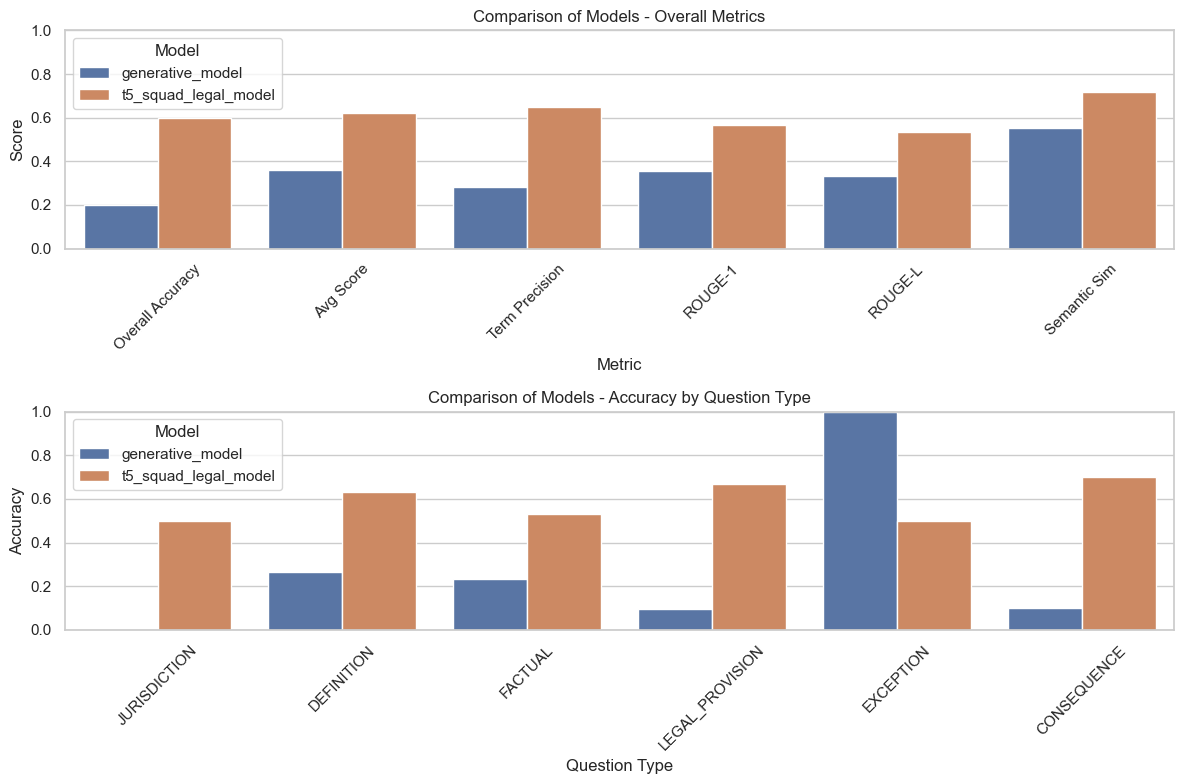


Evaluation complete!


In [37]:
import json
import torch
import numpy as np
import pandas as pd
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import time
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Helper function to make results JSON serializable
def make_json_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64,
                         np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(make_json_serializable(item) for item in obj)
    else:
        return obj

def extract_key_terms(text):
    """Extract key terms from ground truth text for comparison"""
    # Remove common words and keep meaningful terms
    tokens = text.lower().split()
    # Filter out very common words
    common_words = {'the', 'a', 'an', 'is', 'are', 'to', 'of', 'for', 'in', 'on', 'by', 'and', 'or', 'that', 'this', 'with', 'as', 'at', 'from', 'be', 'been', 'was', 'were', 'which', 'has', 'have', 'had'}
    key_terms = [token for token in tokens if token not in common_words and len(token) > 2]
    
    # Add specific legal terms that might be important regardless of length
    legal_terms = ['ipc', 'law', 'act', 'crpc', 'code', 'court', 'judge']
    for term in legal_terms:
        if term in text.lower() and term not in key_terms:
            key_terms.append(term)
    
    # Handle numbers and section references specifically
    section_refs = re.findall(r'section\s+\d+', text.lower())
    for ref in section_refs:
        if ref not in key_terms:
            key_terms.append(ref)
    
    # Extract standalone numbers that might be important (like section numbers)
    numbers = re.findall(r'\b\d+\b', text)
    for num in numbers:
        if num not in key_terms and len(num) > 1:  # Only add significant numbers
            key_terms.append(num)
    
    return key_terms

def evaluate_answer(generated_answer, ground_truth):
    """
    Evaluate the generated answer against ground truth using multiple metrics
    """
    # 1. Key term matching
    required_terms = extract_key_terms(ground_truth)
    terms_found = [term for term in required_terms if term.lower() in generated_answer.lower()]
    
    term_precision = len(terms_found) / len(required_terms) if required_terms else 0
    
    # 2. Calculate simple text similarity (fallback if rouge_score not available)
    try:
        from rouge_score import rouge_scorer
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge_scores = scorer.score(ground_truth, generated_answer)
        rouge1_f1 = rouge_scores['rouge1'].fmeasure
        rouge2_f1 = rouge_scores['rouge2'].fmeasure
        rougeL_f1 = rouge_scores['rougeL'].fmeasure
    except:
        # Fallback if rouge_score not available
        words_ground_truth = set(ground_truth.lower().split())
        words_answer = set(generated_answer.lower().split())
        overlap = len(words_ground_truth.intersection(words_answer))
        
        # Calculate F1 score manually
        precision = overlap / len(words_answer) if words_answer else 0
        recall = overlap / len(words_ground_truth) if words_ground_truth else 0
        rouge1_f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        rouge2_f1 = rouge1_f1 * 0.8  # Approximation
        rougeL_f1 = rouge1_f1 * 0.9  # Approximation
    
    # 3. Calculate semantic similarity using SentenceTransformer
    try:
        embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        ground_truth_emb = embedder.encode([ground_truth])[0]
        answer_emb = embedder.encode([generated_answer])[0]
        semantic_sim = float(cosine_similarity([ground_truth_emb], [answer_emb])[0][0])
    except:
        semantic_sim = 0.0  # Fallback if error
    
    # 4. Calculate combined score
    combined_score = (
        0.4 * term_precision + 
        0.2 * rouge1_f1 + 
        0.2 * rougeL_f1 + 
        0.2 * semantic_sim
    )
    
    # Determine if answer is correct (threshold can be adjusted)
    is_correct = combined_score >= 0.6
    
    return {
        'term_precision': float(term_precision),
        'terms_found': terms_found,
        'required_terms': required_terms,
        'rouge1_f1': float(rouge1_f1),
        'rouge2_f1': float(rouge2_f1),
        'rougeL_f1': float(rougeL_f1),
        'semantic_similarity': float(semantic_sim),
        'combined_score': float(combined_score),
        'is_correct': bool(is_correct)
    }

def evaluate_with_gold_standard(model_path='t5_squad_legal_model', save_results=True):
    """
    Evaluate model performance using the gold standard dataset
    """
    print(f"Evaluating model: {model_path}")
    
    # Load components
    print("Loading components...")
    try:
        context_retriever = ContextRetriever(use_gpu=torch.cuda.is_available())
        context_retriever.load_processed_data('legal_qa_processed.json')
        context_retriever.load_indices(
            'legal_qa_retrieval_indices_bm25.pkl', 
            'legal_qa_retrieval_indices_embeddings.npy'
        )
        print("✓ Context retriever loaded")
    except Exception as e:
        print(f"Error loading context retriever: {str(e)}")
        return None
    
    # Load classifier
    try:
        classifier = QuestionClassifier()
        classifier.load_classifier('question_classifier.pkl')
        print("✓ Question classifier loaded")
    except Exception as e:
        print(f"Error loading classifier: {str(e)}")
        return None
    
    # Load the generative model
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        answer_generator = AnswerExtractorGenerator(device=device)
        answer_generator.load_generative_model(model_path)
        print(f"✓ Answer generator loaded with model: {model_path}")
    except Exception as e:
        print(f"Error loading generative model: {str(e)}")
        return None
    
    # Load evaluation dataset
    try:
        with open('evaluation_dataset.json', 'r') as f:
            evaluation_set = json.load(f)
        print(f"✓ Loaded evaluation dataset with {len(evaluation_set)} questions")
    except Exception as e:
        print(f"Error loading evaluation dataset: {str(e)}")
        return None
    
    # Initialize results
    results = {
        'overall': {'correct': 0, 'total': 0},
        'by_type': {},
        'questions': []
    }
    
    # Process each question
    print("\nProcessing questions...")
    
    for i, item in enumerate(tqdm(evaluation_set)):
        question = item['question']
        ground_truth = item['ground_truth']
        question_type = item['question_type']
        
        # Add question type to results if not present
        if question_type not in results['by_type']:
            results['by_type'][question_type] = {'correct': 0, 'total': 0, 'scores': []}
        
        # Classify question
        classification = classifier.classify_question(question)
        
        # Retrieve contexts
        contexts = context_retriever.retrieve_contexts(
            question, 
            question_type=classification['question_type'],
            retrieval_method='hybrid',
            top_k=5
        )
        context_passages = [ctx['passage'] for ctx in contexts]
        combined_context = " ".join(context_passages[:3])
        
        # Generate answer (force generative model)
        generated_answer = answer_generator.generate_answer(question, combined_context)
        answer_text = generated_answer['answer']
        
        # Evaluate answer with multiple metrics
        evaluation = evaluate_answer(answer_text, ground_truth)
        
        # Update results
        results['overall']['total'] += 1
        results['by_type'][question_type]['total'] += 1
        
        if evaluation['is_correct']:
            results['overall']['correct'] += 1
            results['by_type'][question_type]['correct'] += 1
        
        # Store scores
        results['by_type'][question_type]['scores'].append(evaluation['combined_score'])
        
        # Save detailed result
        results['questions'].append({
            'id': i,
            'question': question,
            'ground_truth': ground_truth,
            'generated_answer': answer_text,
            'evaluation': evaluation,
            'question_type': question_type,
            'classifier_type': classification['question_type'],
            'classifier_confidence': float(classification['confidence'])
        })
    
    # Calculate accuracy metrics
    results['overall']['accuracy'] = results['overall']['correct'] / results['overall']['total']
    results['overall']['avg_score'] = float(np.mean([q['evaluation']['combined_score'] for q in results['questions']]))
    
    for qtype in results['by_type']:
        type_total = results['by_type'][qtype]['total']
        if type_total > 0:
            results['by_type'][qtype]['accuracy'] = results['by_type'][qtype]['correct'] / type_total
            results['by_type'][qtype]['avg_score'] = float(np.mean(results['by_type'][qtype]['scores']))
    
    # Calculate metrics across all questions
    results['metrics'] = {
        'term_precision': float(np.mean([q['evaluation']['term_precision'] for q in results['questions']])),
        'rouge1_f1': float(np.mean([q['evaluation']['rouge1_f1'] for q in results['questions']])),
        'rouge2_f1': float(np.mean([q['evaluation']['rouge2_f1'] for q in results['questions']])),
        'rougeL_f1': float(np.mean([q['evaluation']['rougeL_f1'] for q in results['questions']])),
        'semantic_similarity': float(np.mean([q['evaluation']['semantic_similarity'] for q in results['questions']]))
    }
    
    # Make all results JSON serializable
    results = make_json_serializable(results)
    
    # Save results to file
    if save_results:
        model_name = model_path.replace('/', '_')
        results_path = f"evaluation_results_{model_name}.json"
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"\nDetailed results saved to {results_path}")
    
    # Print summary
    print("\n========== EVALUATION SUMMARY ==========")
    print(f"Model: {model_path}")
    print(f"Overall Accuracy: {results['overall']['accuracy']:.2f}")
    print(f"Average Score: {results['overall']['avg_score']:.2f}")
    print("\nMetrics:")
    for metric, value in results['metrics'].items():
        print(f"  {metric}: {value:.4f}")
    
    print("\nResults by Question Type:")
    for qtype, data in sorted(results['by_type'].items(), key=lambda x: x[1]['avg_score'], reverse=True):
        print(f"  {qtype}: {data['accuracy']:.2f} accuracy ({data['correct']}/{data['total']}), avg score: {data['avg_score']:.2f}")
    
    return results

def compare_models(model_paths):
    """
    Compare multiple models on the gold standard dataset
    """
    # Run evaluation for each model
    all_results = {}
    for model_path in model_paths:
        print(f"\nEvaluating model: {model_path}")
        results = evaluate_with_gold_standard(model_path)
        if results:
            all_results[model_path] = results
    
    # If we have multiple models to compare
    if len(all_results) > 1:
        # Create comparison dataframe
        comparison = {
            'Model': [],
            'Overall Accuracy': [],
            'Avg Score': [],
            'Term Precision': [],
            'ROUGE-1': [],
            'ROUGE-L': [],
            'Semantic Sim': []
        }
        
        # Add data for each model
        for model, results in all_results.items():
            comparison['Model'].append(model)
            comparison['Overall Accuracy'].append(results['overall']['accuracy'])
            comparison['Avg Score'].append(results['overall']['avg_score'])
            comparison['Term Precision'].append(results['metrics']['term_precision'])
            comparison['ROUGE-1'].append(results['metrics']['rouge1_f1'])
            comparison['ROUGE-L'].append(results['metrics']['rougeL_f1'])
            comparison['Semantic Sim'].append(results['metrics']['semantic_similarity'])
        
        # Create dataframe
        df = pd.DataFrame(comparison)
        
        # Print comparison table
        print("\n========== MODEL COMPARISON ==========")
        print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
        
        # Create visualization
        try:
            plt.figure(figsize=(12, 8))
            
            # Plot overall metrics
            plt.subplot(2, 1, 1)
            metrics = ['Overall Accuracy', 'Avg Score', 'Term Precision', 'ROUGE-1', 'ROUGE-L', 'Semantic Sim']
            
            df_plot = df.melt(id_vars=['Model'], value_vars=metrics, 
                              var_name='Metric', value_name='Score')
            
            sns.barplot(x='Metric', y='Score', hue='Model', data=df_plot)
            plt.title('Comparison of Models - Overall Metrics')
            plt.ylim(0, 1)
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Plot accuracy by question type for each model
            plt.subplot(2, 1, 2)
            
            # Prepare data for question type comparison
            qtype_data = {
                'Model': [],
                'Question Type': [],
                'Accuracy': []
            }
            
            for model, results in all_results.items():
                for qtype, data in results['by_type'].items():
                    qtype_data['Model'].append(model)
                    qtype_data['Question Type'].append(qtype)
                    qtype_data['Accuracy'].append(data['accuracy'])
            
            qtype_df = pd.DataFrame(qtype_data)
            
            # Filter to most common question types for readability
            top_qtypes = qtype_df.groupby('Question Type')['Accuracy'].mean().nlargest(6).index
            qtype_df_filtered = qtype_df[qtype_df['Question Type'].isin(top_qtypes)]
            
            sns.barplot(x='Question Type', y='Accuracy', hue='Model', data=qtype_df_filtered)
            plt.title('Comparison of Models - Accuracy by Question Type')
            plt.ylim(0, 1)
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Save figure
            plt.savefig("model_comparison.png", dpi=300, bbox_inches='tight')
            print("Comparison visualization saved as model_comparison.png")
            
            # Show it
            plt.show()
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
        
    return all_results

# Function to run a full evaluation
def run_evaluation():
    print("Legal QA System Evaluation")
    print("=========================\n")
    
    try:
        # Install required package for ROUGE scores if not already installed
        import importlib
        if importlib.util.find_spec("rouge_score") is None:
            print("Installing rouge_score package...")
            import subprocess
            subprocess.check_call(["pip", "install", "rouge-score"])
    except:
        print("Warning: rouge_score package installation failed. Proceeding without ROUGE metrics.")
    
    # Models to evaluate
    models = [
        'generative_model',  # Original model
        't5_squad_legal_model'  # SQuAD fine-tuned model
    ]
    
    # Check which models are available
    available_models = []
    for model in models:
        try:
            if os.path.exists(model) or os.path.exists(model + '/config.json'):
                available_models.append(model)
                print(f"Found model: {model}")
            else:
                print(f"Model not found: {model}")
        except:
            print(f"Error checking model: {model}")
    
    if not available_models:
        print("No models available for evaluation. Please train at least one model first.")
        return
    
    # Run comparison
    comparison_results = compare_models(available_models)
    
    print("\nEvaluation complete!")
    
    # Return results for further analysis
    return comparison_results

# Add error analysis function
def analyze_errors(results):
    """Analyze the types of errors made by the model"""
    error_questions = [q for q in results['questions'] if not q['evaluation']['is_correct']]
    
    print(f"Total errors: {len(error_questions)}/{results['overall']['total']}")
    
    # Group errors by question type
    error_by_type = {}
    for q in error_questions:
        qtype = q['question_type']
        if qtype not in error_by_type:
            error_by_type[qtype] = []
        error_by_type[qtype].append(q)
    
    print("\nErrors by question type:")
    for qtype, questions in sorted(error_by_type.items(), key=lambda x: len(x[1]), reverse=True):
        total_of_type = results['by_type'][qtype]['total']
        error_rate = len(questions) / total_of_type
        print(f"  {qtype}: {len(questions)}/{total_of_type} ({error_rate:.2%})")
    
    # Analyze most common missing terms
    missing_terms = {}
    for q in error_questions:
        for term in q['evaluation']['required_terms']:
            if term not in q['evaluation']['terms_found']:
                if term not in missing_terms:
                    missing_terms[term] = 0
                missing_terms[term] += 1
    
    print("\nMost frequently missing terms:")
    for term, count in sorted(missing_terms.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  '{term}': missing in {count} answers")
    
    # Sample error cases
    print("\nSample error cases:")
    for i, q in enumerate(error_questions[:5]):
        print(f"\nError {i+1}:")
        print(f"Question ({q['question_type']}): {q['question']}")
        print(f"Ground Truth: {q['ground_truth']}")
        print(f"Generated: {q['generated_answer']}")
        print(f"Score: {q['evaluation']['combined_score']:.2f}")
        print(f"Missing terms: {set(q['evaluation']['required_terms']) - set(q['evaluation']['terms_found'])}")

# Run the evaluation
if __name__ == "__main__":
    import os
    # Make sure all necessary packages are imported
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError:
        print("Installing sentence-transformers package...")
        import subprocess
        subprocess.check_call(["pip", "install", "sentence-transformers"])
    
    try:
        import seaborn as sns
    except ImportError:
        print("Installing seaborn package...")
        import subprocess
        subprocess.check_call(["pip", "install", "seaborn"])
    
    # Run evaluation
    results = run_evaluation()

CLEAR HISTORY

In [13]:
# Function to clear the question history
def clear_question_history():
    # Load retrieval system just to clear history
    retrieval_system = QuestionRetrievalSystem(use_sentence_transformer=True)
    
    try:
        # Load current history
        retrieval_system.load_history('question_history.pkl')
        # Get the count for reporting
        history_count = len(retrieval_system.question_history)
        # Clear it
        retrieval_system.question_history = {}
        # Save empty history
        retrieval_system.save_history('question_history.pkl')
        print(f"Question history cleared. {history_count} entries removed.")
    except:
        print("No history file found or error clearing history.")
        # Create an empty history file
        retrieval_system.save_history('question_history.pkl')
        print("New empty history file created.")

clear_question_history()

Loaded 1 historical Q&A pairs from question_history.pkl
Question history saved to question_history.pkl
Question history cleared. 1 entries removed.
